In [1]:
using Plots, LinearAlgebra
import Random
include("./NeuralNetwork.jl")

train! (generic function with 1 method)

We define a simple true model to classify data points as either above or below the model. We will train the neural network to learn this classfication.

In [2]:
model(x) = x^3 - 3x + 2

model (generic function with 1 method)

Next, we define some helpful functions to generate a random data set for the model.

In [3]:
# Sample `size` numbers from `range`
function sample(range, size)
    return rand(size) * (last(range) - first(range)) .+ first(range)
end

# Generate dataset with `size` from the given `x1range`, `x2range`.
function generate_dataset(model, x1range, x2range, size)
    # Sample x and y
    x1s = sample(x1range, size)
    x2s = sample(x2range, size)

    # Create the input matrix
    input = hcat(x1s, x2s)'

    # Classify points to be below or above the model, labeled 0 and 1
    output = Float64.(x2s .≥ model.(x1s))'

    return Array(input), Array(output)
end

generate_dataset (generic function with 1 method)

Now we generate a data set between (-3, 3) on the x-axis and (-16, 20) on the y-axis

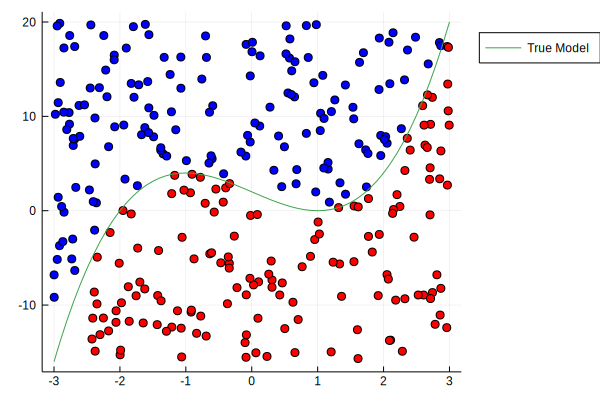

In [4]:
x1grid = -3:0.1:3
x2grid = -16:0.1:20

# Generate the inputs and corresponding outputs
input, output = generate_dataset(model, x1grid, x2grid, 300)

# Plot the data set
ishigher = vec(output .== 1)
function plot_data()
    scatter(input[1, ishigher], input[2, ishigher], label="", color=:blue)
    scatter!(input[1, .!ishigher], input[2, .!ishigher], label="", color=:red)
    plot!(x1grid, model.(x1grid), label="True Model", legend=:outertopright)
end
plot_data()

Let's build our neural network!

In [5]:
### Sigmoid activation function
sigmoid(x) = 1 / (1 + exp(-x))
derive(::typeof(sigmoid)) = x -> sigmoid(x) * (1 - sigmoid(x))

### Relu activation function
relu(x) = max(0, x)
derive(::typeof(relu)) = x -> (x ≥ 0 ? 1 : 0)

### Set up model
neural_model = Model(
    Layer(2, 10, relu),
    Layer(10, 1, sigmoid))

### Cost objective
# Binary cross entropy loss
bcentropy(ŷ, y) = -y * log(ŷ + 1e-7) - (1 - y) * log(1 - ŷ + 1e-7)
derive(::typeof(bcentropy)) = (ŷ, y) -> -y / (ŷ + 2e-7) + (1 - y) / (1 - ŷ + 1e-7)
# Cost function
Cost(Ŷ, Y) = sum(bcentropy.(Ŷ, Y)) / size(Y, 2)
derive(::typeof(Cost)) = (Ŷ, Y) -> derive(bcentropy).(Ŷ, Y) / size(Y, 2)

### Minibatching
function minibatch(input, output, batch_size)
    @assert size(input, 2) == size(output, 2) "Numbers of input and output doesn't match."
    inputs = Array[]
    outputs = Array[]

    rand_idxs = Random.randperm(size(input, 2))
    batch_idxs = Iterators.partition(rand_idxs, batch_size)
    for batch_idx in batch_idxs
        push!(inputs, input[:, batch_idx])
        push!(outputs, output[:, batch_idx])
    end

    zip(inputs, outputs) |> collect
end

### Model visualization
function plot_model(neural_model, x1grid, x2grid)
    plot_data()
    bound = fill(maximum(x2grid), size(x1grid))

    # Classify each point
    for (i, x1) in enumerate(x1grid)
        for x2 in x2grid
            out = neural_model([x1, x2])[end]
            if out ≥ 0.5
                bound[i] = x2
                break
            end
         end
    end

    plot!(x1grid, bound, label="Neural Network Model")
end

plot_model (generic function with 1 method)

Finally, train our model on the generated data set

In [6]:
η = 0.01 # learning rate
max_epoch = 3000 # maximum iteration
anim = Animation() # visualization

### Training loop
for i in 1:max_epoch
    dataset = minibatch(input, output, 5)

    # Train model
    cost = train!(neural_model, Cost, dataset, η)

    # Report loss
    println("Epoch $i cost: $cost")

    # Update visualization
    if i % 10 == 0
        plot_model(neural_model, x1grid, x2grid)
        frame(anim)
    end
end

Epoch 1 cost: 0.4679027718801993
Epoch 2 cost: 0.3829917340132341
Epoch 3 cost: 0.3461130251191534
Epoch 4 cost: 0.3343860943410487
Epoch 5 cost: 0.3286560688612599
Epoch 6 cost: 0.3225921848402657
Epoch 7 cost: 0.319027921517198
Epoch 8 cost: 0.31486414711540134
Epoch 9 cost: 0.31306393881344496
Epoch 10 cost: 0.30897008444770113


Epoch 11 cost: 0.3072300135508509
Epoch 12 cost: 0.3055428957567413
Epoch 13 cost: 0.3040547905672446
Epoch 14 cost: 0.30266531395785606
Epoch 15 cost: 0.2998820102829654
Epoch 16 cost: 0.29954622830468236
Epoch 17 cost: 0.2986984215205011
Epoch 18 cost: 0.29473365160927745
Epoch 19 cost: 0.29049188213554505
Epoch 20 cost: 0.29109311606248106


Epoch 21 cost: 0.2905885153839007
Epoch 22 cost: 0.28868653172491243
Epoch 23 cost: 0.290071771632941
Epoch 24 cost: 0.2851697338915312
Epoch 25 cost: 0.2846537940431935
Epoch 26 cost: 0.28089825677265556
Epoch 27 cost: 0.2800871313368674
Epoch 28 cost: 0.27900427617180096
Epoch 29 cost: 0.2803134658807675
Epoch 30 cost: 0.278357293394078


Epoch 31 cost: 0.27586128937207494
Epoch 32 cost: 0.27584873383459246
Epoch 33 cost: 0.27481460613523434
Epoch 34 cost: 0.2754761480870788
Epoch 35 cost: 0.27464035348838667
Epoch 36 cost: 0.2718621641137973
Epoch 37 cost: 0.27285989845301295
Epoch 38 cost: 0.2771119664188013
Epoch 39 cost: 0.27187794165912466
Epoch 40 cost: 0.27102138774191803


Epoch 41 cost: 0.27201017112659276
Epoch 42 cost: 0.26830007687311874
Epoch 43 cost: 0.2696458860583955
Epoch 44 cost: 0.2702586761767705
Epoch 45 cost: 0.26783234439993564
Epoch 46 cost: 0.2687610704361345
Epoch 47 cost: 0.26770106387595416
Epoch 48 cost: 0.2702076104261544
Epoch 49 cost: 0.2759272552407715
Epoch 50 cost: 0.2744337594011969


Epoch 51 cost: 0.2655664315607569
Epoch 52 cost: 0.26452773680368336
Epoch 53 cost: 0.2634051203221009
Epoch 54 cost: 0.26325124333775884
Epoch 55 cost: 0.2652405025006129
Epoch 56 cost: 0.27405160913642324
Epoch 57 cost: 0.26128045904641917
Epoch 58 cost: 0.263039973277614
Epoch 59 cost: 0.2617748386730017
Epoch 60 cost: 0.25999800195704975


Epoch 61 cost: 0.258867725001568
Epoch 62 cost: 0.2595275187044679
Epoch 63 cost: 0.2594796446495346
Epoch 64 cost: 0.263319507198727
Epoch 65 cost: 0.2612764027115163
Epoch 66 cost: 0.25644976550049553
Epoch 67 cost: 0.25570561631327077
Epoch 68 cost: 0.2581631153318934
Epoch 69 cost: 0.26376868299013106
Epoch 70 cost: 0.26143767138901053


Epoch 71 cost: 0.2585395639781875
Epoch 72 cost: 0.2578326127021605
Epoch 73 cost: 0.25588410992041244
Epoch 74 cost: 0.2563440737610043
Epoch 75 cost: 0.258584044949524
Epoch 76 cost: 0.26090339338901136
Epoch 77 cost: 0.25294822259251654
Epoch 78 cost: 0.25418015894222706
Epoch 79 cost: 0.25356336819808134
Epoch 80 cost: 0.25901721866789473


Epoch 81 cost: 0.2617400981389347
Epoch 82 cost: 0.257939324038013
Epoch 83 cost: 0.2550709892643654
Epoch 84 cost: 0.2543223275201447
Epoch 85 cost: 0.2526621876203652
Epoch 86 cost: 0.2746591134192965
Epoch 87 cost: 0.2617910218219588
Epoch 88 cost: 0.2565167772826482
Epoch 89 cost: 0.25473150536389927
Epoch 90 cost: 0.25176397825903823


Epoch 91 cost: 0.25101506164647674
Epoch 92 cost: 0.2503710214221758
Epoch 93 cost: 0.25154237867651047
Epoch 94 cost: 0.2572794322155968
Epoch 95 cost: 0.24934769734591072
Epoch 96 cost: 0.24779497929288186
Epoch 97 cost: 0.2482574366137823
Epoch 98 cost: 0.24897169036582667
Epoch 99 cost: 0.2509951550282035
Epoch 100 cost: 0.25920970101683916


Epoch 101 cost: 0.25228076408863165
Epoch 102 cost: 0.2513498022373953
Epoch 103 cost: 0.24651101547034643
Epoch 104 cost: 0.24990826898921853
Epoch 105 cost: 0.2508803232539031
Epoch 106 cost: 0.2518918339614414
Epoch 107 cost: 0.24818265395561676
Epoch 108 cost: 0.24835945237698853
Epoch 109 cost: 0.25008221143476866
Epoch 110 cost: 0.24892853918896976


Epoch 111 cost: 0.25167795988232694
Epoch 112 cost: 0.25028947077874525
Epoch 113 cost: 0.2523062030029159
Epoch 114 cost: 0.25476196736503914
Epoch 115 cost: 0.2557089616619137
Epoch 116 cost: 0.25563525008005594
Epoch 117 cost: 0.24679294312474137
Epoch 118 cost: 0.25097300076899726
Epoch 119 cost: 0.25674179816666637
Epoch 120 cost: 0.24897793645956814


Epoch 121 cost: 0.2530913129293297
Epoch 122 cost: 0.24856804515268885
Epoch 123 cost: 0.24845883620097692
Epoch 124 cost: 0.24894671260598458
Epoch 125 cost: 0.2449923691652905
Epoch 126 cost: 0.24499386398901832
Epoch 127 cost: 0.2482916683745689
Epoch 128 cost: 0.252003047636508
Epoch 129 cost: 0.2502101857178105
Epoch 130 cost: 0.25023422206027257


Epoch 131 cost: 0.2480684254413779
Epoch 132 cost: 0.24979804331958416
Epoch 133 cost: 0.24879142795999798
Epoch 134 cost: 0.24375050618995633
Epoch 135 cost: 0.24625013582602115
Epoch 136 cost: 0.24550188941304923
Epoch 137 cost: 0.24426308198672922
Epoch 138 cost: 0.24728980298912423
Epoch 139 cost: 0.24709574205273344
Epoch 140 cost: 0.2440186343479292


Epoch 141 cost: 0.24400392891940959
Epoch 142 cost: 0.2452719403801786
Epoch 143 cost: 0.24773583249039102
Epoch 144 cost: 0.24571513230961498
Epoch 145 cost: 0.2402693596156806
Epoch 146 cost: 0.24717587370861543
Epoch 147 cost: 0.24812312671520922
Epoch 148 cost: 0.2451632577793053
Epoch 149 cost: 0.24502505587971385
Epoch 150 cost: 0.24675946992477796


Epoch 151 cost: 0.24349840016408297
Epoch 152 cost: 0.24322252802859332
Epoch 153 cost: 0.24523894006134891
Epoch 154 cost: 0.2443364246133098
Epoch 155 cost: 0.24538954330365303
Epoch 156 cost: 0.24899987066652776
Epoch 157 cost: 0.24219493982699683
Epoch 158 cost: 0.24514478506990497
Epoch 159 cost: 0.24718047531710263
Epoch 160 cost: 0.2486185905326589


Epoch 161 cost: 0.2457348710094081
Epoch 162 cost: 0.2463441875272453
Epoch 163 cost: 0.2486959002283342
Epoch 164 cost: 0.2519778304975041
Epoch 165 cost: 0.2457019308757088
Epoch 166 cost: 0.24454864339420695
Epoch 167 cost: 0.24203119625587372
Epoch 168 cost: 0.24022373743487624
Epoch 169 cost: 0.24631705857026603
Epoch 170 cost: 0.24451667830314516


Epoch 171 cost: 0.24205318484806002
Epoch 172 cost: 0.24094125677448203
Epoch 173 cost: 0.2414425990206756
Epoch 174 cost: 0.2429086562601085
Epoch 175 cost: 0.2419115917265988
Epoch 176 cost: 0.24009824723998724
Epoch 177 cost: 0.2401470123396127
Epoch 178 cost: 0.2417908911777062
Epoch 179 cost: 0.23821351923347278
Epoch 180 cost: 0.24123916917417518


Epoch 181 cost: 0.23807487436978622
Epoch 182 cost: 0.23794579233467764
Epoch 183 cost: 0.23875786755220735
Epoch 184 cost: 0.23950472163788197
Epoch 185 cost: 0.23962765006195264
Epoch 186 cost: 0.23936101833384674
Epoch 187 cost: 0.23915322446023182
Epoch 188 cost: 0.23840420667185766
Epoch 189 cost: 0.2390076088345359
Epoch 190 cost: 0.23886785406809866


Epoch 191 cost: 0.24058854507236038
Epoch 192 cost: 0.2401998406540981
Epoch 193 cost: 0.2416380168777639
Epoch 194 cost: 0.24068539002002307
Epoch 195 cost: 0.23856252584768597
Epoch 196 cost: 0.2414703322104311
Epoch 197 cost: 0.24050660465076917
Epoch 198 cost: 0.23920902484298862
Epoch 199 cost: 0.2422456684842495
Epoch 200 cost: 0.23830049215452448


Epoch 201 cost: 0.23856906011316925
Epoch 202 cost: 0.24270057296978656
Epoch 203 cost: 0.23974194689707573
Epoch 204 cost: 0.23884539050459436
Epoch 205 cost: 0.24340699660233386
Epoch 206 cost: 0.2379853752146462
Epoch 207 cost: 0.23632188226321496
Epoch 208 cost: 0.2366130969040501
Epoch 209 cost: 0.24138726658941134
Epoch 210 cost: 0.23568461922599093


Epoch 211 cost: 0.23556360413384791
Epoch 212 cost: 0.23842295594624277
Epoch 213 cost: 0.23899751585886514
Epoch 214 cost: 0.23475834515441518
Epoch 215 cost: 0.23941233163793593
Epoch 216 cost: 0.23890762805223087
Epoch 217 cost: 0.23817229481463603
Epoch 218 cost: 0.23355557391860401
Epoch 219 cost: 0.23833027887364863
Epoch 220 cost: 0.2369141410006021


Epoch 221 cost: 0.24057679975965426
Epoch 222 cost: 0.24097506957354725
Epoch 223 cost: 0.23761405061646418
Epoch 224 cost: 0.2381722431591526
Epoch 225 cost: 0.23733491300151008
Epoch 226 cost: 0.23768364667905895
Epoch 227 cost: 0.2384324621997532
Epoch 228 cost: 0.24064720224693925
Epoch 229 cost: 0.23739765280046227
Epoch 230 cost: 0.23527479034981186


Epoch 231 cost: 0.24094309459098506
Epoch 232 cost: 0.23627448747896843
Epoch 233 cost: 0.23648806011950002
Epoch 234 cost: 0.23996797338213235
Epoch 235 cost: 0.2397272455332685
Epoch 236 cost: 0.23648122540648703
Epoch 237 cost: 0.23647538685237085
Epoch 238 cost: 0.23701309236897092
Epoch 239 cost: 0.2395676595800743
Epoch 240 cost: 0.238412675723578


Epoch 241 cost: 0.23638905673942642
Epoch 242 cost: 0.23688714369282274
Epoch 243 cost: 0.23546105568366682
Epoch 244 cost: 0.2379452235768816
Epoch 245 cost: 0.239095929986566
Epoch 246 cost: 0.2362218498354642
Epoch 247 cost: 0.2358605577370862
Epoch 248 cost: 0.23522407034363493
Epoch 249 cost: 0.2353097520106909
Epoch 250 cost: 0.2379081319179695


Epoch 251 cost: 0.23516784894992523
Epoch 252 cost: 0.23917897619051118
Epoch 253 cost: 0.2426993989653181
Epoch 254 cost: 0.2366004405041138
Epoch 255 cost: 0.23613163804341755
Epoch 256 cost: 0.23580423661843775
Epoch 257 cost: 0.23545136770663114
Epoch 258 cost: 0.2358237666266086
Epoch 259 cost: 0.23776216549631699
Epoch 260 cost: 0.2348514492393394


Epoch 261 cost: 0.23740776809699463
Epoch 262 cost: 0.2331501004920397
Epoch 263 cost: 0.23437413085097117
Epoch 264 cost: 0.23661676330903303
Epoch 265 cost: 0.23478173885836068
Epoch 266 cost: 0.23422723284276364
Epoch 267 cost: 0.23936665355937117
Epoch 268 cost: 0.23665987401666733
Epoch 269 cost: 0.24261840798204046
Epoch 270 cost: 0.23585978797121168


Epoch 271 cost: 0.23537444201650895
Epoch 272 cost: 0.23415421863761007
Epoch 273 cost: 0.23375191344507715
Epoch 274 cost: 0.23538453264302378
Epoch 275 cost: 0.2338545904344367
Epoch 276 cost: 0.23410542287580308
Epoch 277 cost: 0.23323613583372355
Epoch 278 cost: 0.23754790926858588
Epoch 279 cost: 0.23543875730406855
Epoch 280 cost: 0.23208614755812382


Epoch 281 cost: 0.2322822809298915
Epoch 282 cost: 0.2320733358023362
Epoch 283 cost: 0.23700981086214845
Epoch 284 cost: 0.23317259629810397
Epoch 285 cost: 0.23312682656777844
Epoch 286 cost: 0.23260134021423
Epoch 287 cost: 0.23261030397036359
Epoch 288 cost: 0.233295766493458
Epoch 289 cost: 0.23087501186185577
Epoch 290 cost: 0.22993088116658902


Epoch 291 cost: 0.23929743332946452
Epoch 292 cost: 0.2350782999937634
Epoch 293 cost: 0.2347674602728608
Epoch 294 cost: 0.23367916535170175
Epoch 295 cost: 0.23571454389739635
Epoch 296 cost: 0.23089771085174082
Epoch 297 cost: 0.23356645933705886
Epoch 298 cost: 0.23370773613297502
Epoch 299 cost: 0.228123423300675
Epoch 300 cost: 0.23665358007642182


Epoch 301 cost: 0.2342818258177796
Epoch 302 cost: 0.2323018174973917
Epoch 303 cost: 0.23154627740608266
Epoch 304 cost: 0.2324840926522325
Epoch 305 cost: 0.2307539568125143
Epoch 306 cost: 0.22936947122752474
Epoch 307 cost: 0.23059461273893184
Epoch 308 cost: 0.23471111071064085
Epoch 309 cost: 0.23337474927305124
Epoch 310 cost: 0.2303396564278826


Epoch 311 cost: 0.23136062969842613
Epoch 312 cost: 0.2274922592300544
Epoch 313 cost: 0.23133928328722025
Epoch 314 cost: 0.23408351784390338
Epoch 315 cost: 0.23163583687531922
Epoch 316 cost: 0.23075981638361914
Epoch 317 cost: 0.23357464852412227
Epoch 318 cost: 0.23637059526431564
Epoch 319 cost: 0.23036537826391568
Epoch 320 cost: 0.23387988241255464


Epoch 321 cost: 0.2320487162982073
Epoch 322 cost: 0.23097659226757283
Epoch 323 cost: 0.2300267979779664
Epoch 324 cost: 0.23077061231211296
Epoch 325 cost: 0.2282770863041417
Epoch 326 cost: 0.2370489213609649
Epoch 327 cost: 0.23495930248111127
Epoch 328 cost: 0.23013440867847518
Epoch 329 cost: 0.2303275006078291
Epoch 330 cost: 0.23154355126139364


Epoch 331 cost: 0.23145008171519182
Epoch 332 cost: 0.23281128426636177
Epoch 333 cost: 0.22804314480715746
Epoch 334 cost: 0.22860287230599302
Epoch 335 cost: 0.23181698513742086
Epoch 336 cost: 0.23043409923763306
Epoch 337 cost: 0.2290137952487911
Epoch 338 cost: 0.2278182732607036
Epoch 339 cost: 0.2302725969107781
Epoch 340 cost: 0.22953646445802917


Epoch 341 cost: 0.22877487130520072
Epoch 342 cost: 0.22972025125792456
Epoch 343 cost: 0.22900433660235786
Epoch 344 cost: 0.22743061112312882
Epoch 345 cost: 0.2266047022093453
Epoch 346 cost: 0.23028593592968827
Epoch 347 cost: 0.22720594809709443
Epoch 348 cost: 0.22734411496450757
Epoch 349 cost: 0.22562166873734182
Epoch 350 cost: 0.22724096426153526


Epoch 351 cost: 0.22820207246375965
Epoch 352 cost: 0.22782347500892483
Epoch 353 cost: 0.22771701882959172
Epoch 354 cost: 0.2274453349819475
Epoch 355 cost: 0.2259368061655543
Epoch 356 cost: 0.23002346524578604
Epoch 357 cost: 0.2292560191922524
Epoch 358 cost: 0.2265329859338281
Epoch 359 cost: 0.22765067322552912
Epoch 360 cost: 0.22759825923867194


Epoch 361 cost: 0.2271950143328084
Epoch 362 cost: 0.2246197260752844
Epoch 363 cost: 0.22558481545895528
Epoch 364 cost: 0.22440999303518264
Epoch 365 cost: 0.23113949503673306
Epoch 366 cost: 0.22564735253919058
Epoch 367 cost: 0.23157805044169463
Epoch 368 cost: 0.22612545962001926
Epoch 369 cost: 0.22497651650301517
Epoch 370 cost: 0.22620804995784466


Epoch 371 cost: 0.22325299832020465
Epoch 372 cost: 0.2257447817683239
Epoch 373 cost: 0.23005094110992333
Epoch 374 cost: 0.23169808901814762
Epoch 375 cost: 0.23102598693596088
Epoch 376 cost: 0.2322341210701549
Epoch 377 cost: 0.2310010123249892
Epoch 378 cost: 0.22655112635417157
Epoch 379 cost: 0.22397941639315413
Epoch 380 cost: 0.2248304822671631


Epoch 381 cost: 0.22043636838514322
Epoch 382 cost: 0.22362722034731425
Epoch 383 cost: 0.22596392725943784
Epoch 384 cost: 0.22093425817508863
Epoch 385 cost: 0.2257238658728216
Epoch 386 cost: 0.22380021618077095
Epoch 387 cost: 0.22254169487383918
Epoch 388 cost: 0.22354187989601956
Epoch 389 cost: 0.22407713381909902
Epoch 390 cost: 0.22665455000928522


Epoch 391 cost: 0.2248285086755576
Epoch 392 cost: 0.22138608996634732
Epoch 393 cost: 0.2275919885160816
Epoch 394 cost: 0.22287008319725404
Epoch 395 cost: 0.2221106599214188
Epoch 396 cost: 0.22102370173400082
Epoch 397 cost: 0.2202719418726876
Epoch 398 cost: 0.22048531231425444
Epoch 399 cost: 0.2209843848498858
Epoch 400 cost: 0.22419398886656358


Epoch 401 cost: 0.2215181014424744
Epoch 402 cost: 0.2184359940892039
Epoch 403 cost: 0.2219633162825555
Epoch 404 cost: 0.22431849190357622
Epoch 405 cost: 0.21863691176418223
Epoch 406 cost: 0.22446401269158414
Epoch 407 cost: 0.2186823036550578
Epoch 408 cost: 0.22014676900915817
Epoch 409 cost: 0.2231584611641345
Epoch 410 cost: 0.21800137185118143


Epoch 411 cost: 0.21936057910210194
Epoch 412 cost: 0.21840897250443245
Epoch 413 cost: 0.21824092008645066
Epoch 414 cost: 0.21621536554905807
Epoch 415 cost: 0.22088523457081874
Epoch 416 cost: 0.22460237477407835
Epoch 417 cost: 0.21542359280443357
Epoch 418 cost: 0.21607213918145649
Epoch 419 cost: 0.21922335302145732
Epoch 420 cost: 0.21693473253352571


Epoch 421 cost: 0.21766608832120254
Epoch 422 cost: 0.21368916115403394
Epoch 423 cost: 0.21747958657417152
Epoch 424 cost: 0.21402687370669607
Epoch 425 cost: 0.21390366382077106
Epoch 426 cost: 0.2139021548290727
Epoch 427 cost: 0.2149184604598766
Epoch 428 cost: 0.21443749941822904
Epoch 429 cost: 0.2141959936005219
Epoch 430 cost: 0.21346800123904963


Epoch 431 cost: 0.21023983322455578
Epoch 432 cost: 0.21566026981227787
Epoch 433 cost: 0.2147388111984864
Epoch 434 cost: 0.21293499610904398
Epoch 435 cost: 0.21464046242141124
Epoch 436 cost: 0.21257244748592105
Epoch 437 cost: 0.2141455433176124
Epoch 438 cost: 0.2137513650767103
Epoch 439 cost: 0.21339124023521977
Epoch 440 cost: 0.21168186449002163


Epoch 441 cost: 0.2118370146867335
Epoch 442 cost: 0.21431151328466383
Epoch 443 cost: 0.21254275147992724
Epoch 444 cost: 0.21201298269269372
Epoch 445 cost: 0.21472277681448565
Epoch 446 cost: 0.21354358634068787
Epoch 447 cost: 0.2112872469352392
Epoch 448 cost: 0.2151091165046798
Epoch 449 cost: 0.21588090939767524
Epoch 450 cost: 0.21222843946642436


Epoch 451 cost: 0.21111712382653824
Epoch 452 cost: 0.21020887367827942
Epoch 453 cost: 0.20835942842032468
Epoch 454 cost: 0.21126214903389934
Epoch 455 cost: 0.21342564420128965
Epoch 456 cost: 0.20959116684656182
Epoch 457 cost: 0.2110183310393439
Epoch 458 cost: 0.21296147233879623
Epoch 459 cost: 0.20853790305233602
Epoch 460 cost: 0.20907749636959733


Epoch 461 cost: 0.20839754994570742
Epoch 462 cost: 0.21211231835166686
Epoch 463 cost: 0.21182539415149396
Epoch 464 cost: 0.20929619418120712
Epoch 465 cost: 0.2070500846308816
Epoch 466 cost: 0.20712139882169575
Epoch 467 cost: 0.209030793703228
Epoch 468 cost: 0.20992202847389202
Epoch 469 cost: 0.21107309085905673
Epoch 470 cost: 0.20945892809081013


Epoch 471 cost: 0.21325879436812747
Epoch 472 cost: 0.20588209671336935
Epoch 473 cost: 0.20864792613873673
Epoch 474 cost: 0.20939232457184867
Epoch 475 cost: 0.20757473187811887
Epoch 476 cost: 0.20844536409619016
Epoch 477 cost: 0.20965248180798787
Epoch 478 cost: 0.21116874759350177
Epoch 479 cost: 0.21004722433061396
Epoch 480 cost: 0.20733124830420255


Epoch 481 cost: 0.2088566600931502
Epoch 482 cost: 0.2116738848019256
Epoch 483 cost: 0.2100474305369234
Epoch 484 cost: 0.20775334095310163
Epoch 485 cost: 0.20799464435557707
Epoch 486 cost: 0.20821495736049261
Epoch 487 cost: 0.21160688731782815
Epoch 488 cost: 0.2078555094327469
Epoch 489 cost: 0.20916085223281553
Epoch 490 cost: 0.20634357157376704


Epoch 491 cost: 0.2092691644362939
Epoch 492 cost: 0.20766827766920792
Epoch 493 cost: 0.20616015346743907
Epoch 494 cost: 0.20366181109769596
Epoch 495 cost: 0.2041654669865364
Epoch 496 cost: 0.2027797234083775
Epoch 497 cost: 0.20274991249428545
Epoch 498 cost: 0.21358777465971038
Epoch 499 cost: 0.20928336040895762
Epoch 500 cost: 0.20233394134058635


Epoch 501 cost: 0.20229187996350345
Epoch 502 cost: 0.20650614122863534
Epoch 503 cost: 0.205177063133377
Epoch 504 cost: 0.2063634770613094
Epoch 505 cost: 0.2040823259943872
Epoch 506 cost: 0.20190104217638677
Epoch 507 cost: 0.20203585747705122
Epoch 508 cost: 0.19939597422489988
Epoch 509 cost: 0.2029009255905259
Epoch 510 cost: 0.20149000798420422


Epoch 511 cost: 0.20549025328261825
Epoch 512 cost: 0.20749202270198952
Epoch 513 cost: 0.2005686545697572
Epoch 514 cost: 0.20232054440573916
Epoch 515 cost: 0.20193451637735993
Epoch 516 cost: 0.2061573441205177
Epoch 517 cost: 0.19856405598538235
Epoch 518 cost: 0.20150807446814337
Epoch 519 cost: 0.20288807852631346
Epoch 520 cost: 0.20449431842674082


Epoch 521 cost: 0.20062799702864942
Epoch 522 cost: 0.2024551580282083
Epoch 523 cost: 0.20168367542906104
Epoch 524 cost: 0.2018563616494847
Epoch 525 cost: 0.20061953452812556
Epoch 526 cost: 0.20238754480132953
Epoch 527 cost: 0.1990217322808683
Epoch 528 cost: 0.19877417943407505
Epoch 529 cost: 0.20258947492969273
Epoch 530 cost: 0.20882259045956006


Epoch 531 cost: 0.2038904958257591
Epoch 532 cost: 0.19831445067668968
Epoch 533 cost: 0.19648123744391696
Epoch 534 cost: 0.1995405913704139
Epoch 535 cost: 0.2002340690719334
Epoch 536 cost: 0.20414821320682972
Epoch 537 cost: 0.20560811777890362
Epoch 538 cost: 0.20133593370149314
Epoch 539 cost: 0.19881031243646005
Epoch 540 cost: 0.1986684780837469


Epoch 541 cost: 0.19593093361447433
Epoch 542 cost: 0.1986042139192347
Epoch 543 cost: 0.20371307400963753
Epoch 544 cost: 0.19859971440842278
Epoch 545 cost: 0.19629929264177154
Epoch 546 cost: 0.1947606481363363
Epoch 547 cost: 0.19476233582647653
Epoch 548 cost: 0.19497983731237398
Epoch 549 cost: 0.19677973824300823
Epoch 550 cost: 0.19255398568555235


Epoch 551 cost: 0.20115336147894666
Epoch 552 cost: 0.2049520518197369
Epoch 553 cost: 0.19784773196210723
Epoch 554 cost: 0.1961923294794023
Epoch 555 cost: 0.19334275180245747
Epoch 556 cost: 0.19318579805551087
Epoch 557 cost: 0.19752875640150586
Epoch 558 cost: 0.19560126833114497
Epoch 559 cost: 0.19638315461642933
Epoch 560 cost: 0.19866441285411202


Epoch 561 cost: 0.19972325867115492
Epoch 562 cost: 0.19205926074734042
Epoch 563 cost: 0.19261105730731107
Epoch 564 cost: 0.1977100731961925
Epoch 565 cost: 0.1942927561621282
Epoch 566 cost: 0.19241551012996394
Epoch 567 cost: 0.19162551800819835
Epoch 568 cost: 0.19047160925675638
Epoch 569 cost: 0.18913892701130602
Epoch 570 cost: 0.19410520494356


Epoch 571 cost: 0.19143824534346487
Epoch 572 cost: 0.19041476450037703
Epoch 573 cost: 0.19035192386281313
Epoch 574 cost: 0.19150393874128335
Epoch 575 cost: 0.1907778905799499
Epoch 576 cost: 0.18984062570319968
Epoch 577 cost: 0.19179373871401081
Epoch 578 cost: 0.1892687276379357
Epoch 579 cost: 0.19196171531813835
Epoch 580 cost: 0.19120631081115852


Epoch 581 cost: 0.18799935584946528
Epoch 582 cost: 0.19064135644470306
Epoch 583 cost: 0.1901371700927579
Epoch 584 cost: 0.1895546967065095
Epoch 585 cost: 0.1945805253850448
Epoch 586 cost: 0.18759383094165719
Epoch 587 cost: 0.18848702295713868
Epoch 588 cost: 0.18810293205344045
Epoch 589 cost: 0.18894164718654335
Epoch 590 cost: 0.18779490538275964


Epoch 591 cost: 0.19349973821633573
Epoch 592 cost: 0.1878549213930402
Epoch 593 cost: 0.189261807710705
Epoch 594 cost: 0.18816956258571044
Epoch 595 cost: 0.1954463856088381
Epoch 596 cost: 0.18808048764606092
Epoch 597 cost: 0.1859577591646216
Epoch 598 cost: 0.18651006985138727
Epoch 599 cost: 0.18643249346716606
Epoch 600 cost: 0.1875729740080084


Epoch 601 cost: 0.18484237889531227
Epoch 602 cost: 0.1839089507161364
Epoch 603 cost: 0.18625767083597572
Epoch 604 cost: 0.1859653526538386
Epoch 605 cost: 0.18362717006044657
Epoch 606 cost: 0.18427673510011638
Epoch 607 cost: 0.18323167593629539
Epoch 608 cost: 0.18822489394705771
Epoch 609 cost: 0.18481664678373885
Epoch 610 cost: 0.1846877716018905


Epoch 611 cost: 0.18460261515456142
Epoch 612 cost: 0.18915582226333916
Epoch 613 cost: 0.18422238631326918
Epoch 614 cost: 0.18796797538207705
Epoch 615 cost: 0.18819325332540243
Epoch 616 cost: 0.19484438167572204
Epoch 617 cost: 0.18718405171828287
Epoch 618 cost: 0.1853893534328216
Epoch 619 cost: 0.18252436165858196
Epoch 620 cost: 0.18456314982859165


Epoch 621 cost: 0.1855569559476587
Epoch 622 cost: 0.18517805544258037
Epoch 623 cost: 0.18609547069924146
Epoch 624 cost: 0.183524480090756
Epoch 625 cost: 0.18432358797210888
Epoch 626 cost: 0.18443511665133358
Epoch 627 cost: 0.18369859460210466
Epoch 628 cost: 0.17975491873965227
Epoch 629 cost: 0.1904937643903321
Epoch 630 cost: 0.18992702732683606


Epoch 631 cost: 0.18173196672509165
Epoch 632 cost: 0.18141570625364423
Epoch 633 cost: 0.18225294563766
Epoch 634 cost: 0.1863653652342667
Epoch 635 cost: 0.18452985148684903
Epoch 636 cost: 0.18156395258109798
Epoch 637 cost: 0.18734722453879865
Epoch 638 cost: 0.18990761293337088
Epoch 639 cost: 0.18816571255725761
Epoch 640 cost: 0.18496766931303898


Epoch 641 cost: 0.180587153482452
Epoch 642 cost: 0.1806337325431963
Epoch 643 cost: 0.18400534011007516
Epoch 644 cost: 0.18163201593490658
Epoch 645 cost: 0.17966982746560925
Epoch 646 cost: 0.17688418383478022
Epoch 647 cost: 0.1789217057137022
Epoch 648 cost: 0.1772185185750175
Epoch 649 cost: 0.1790495908207107
Epoch 650 cost: 0.18111739815772043


Epoch 651 cost: 0.180930835487235
Epoch 652 cost: 0.1793606200464395
Epoch 653 cost: 0.18208473288093005
Epoch 654 cost: 0.17926947640563723
Epoch 655 cost: 0.176566261443591
Epoch 656 cost: 0.18496037891456565
Epoch 657 cost: 0.17570189681948337
Epoch 658 cost: 0.17578656441096238
Epoch 659 cost: 0.17580281309532253
Epoch 660 cost: 0.17543556946617875


Epoch 661 cost: 0.17436812184740746
Epoch 662 cost: 0.17796437883647637
Epoch 663 cost: 0.17773800750311472
Epoch 664 cost: 0.17954352342168944
Epoch 665 cost: 0.1891935346234098
Epoch 666 cost: 0.1850706832960676
Epoch 667 cost: 0.1717021363505828
Epoch 668 cost: 0.1731185958363663
Epoch 669 cost: 0.17628392043740515
Epoch 670 cost: 0.1747761830038942


Epoch 671 cost: 0.1774928635830172
Epoch 672 cost: 0.1743579562961325
Epoch 673 cost: 0.1753614971720607
Epoch 674 cost: 0.17572435296335803
Epoch 675 cost: 0.17527071477149503
Epoch 676 cost: 0.18317710237715748
Epoch 677 cost: 0.1761669754187111
Epoch 678 cost: 0.17632111171267276
Epoch 679 cost: 0.1739294531057572
Epoch 680 cost: 0.17044030104407243


Epoch 681 cost: 0.17251651082027702
Epoch 682 cost: 0.17437255112358382
Epoch 683 cost: 0.17549681988140708
Epoch 684 cost: 0.1716589931602544
Epoch 685 cost: 0.16782372443279767
Epoch 686 cost: 0.17028359831024123
Epoch 687 cost: 0.1736942127464305
Epoch 688 cost: 0.17127578308541708
Epoch 689 cost: 0.17072223381389837
Epoch 690 cost: 0.1763638328024267


Epoch 691 cost: 0.17299935092719887
Epoch 692 cost: 0.17401571646180874
Epoch 693 cost: 0.17151849596424237
Epoch 694 cost: 0.17164375085292546
Epoch 695 cost: 0.17135862530784826
Epoch 696 cost: 0.1694802828217345
Epoch 697 cost: 0.1708052527765413
Epoch 698 cost: 0.17123796350277162
Epoch 699 cost: 0.16745508771431972
Epoch 700 cost: 0.16962014545224016


Epoch 701 cost: 0.16911825791330787
Epoch 702 cost: 0.1668895988950294
Epoch 703 cost: 0.16728790181496703
Epoch 704 cost: 0.1692014555618764
Epoch 705 cost: 0.17002747255987408
Epoch 706 cost: 0.16814495065443272
Epoch 707 cost: 0.17826925948809424
Epoch 708 cost: 0.16779334608677857
Epoch 709 cost: 0.17136219201651934
Epoch 710 cost: 0.17408050660744445


Epoch 711 cost: 0.1699582784065874
Epoch 712 cost: 0.1770700619770755
Epoch 713 cost: 0.1669003596169323
Epoch 714 cost: 0.16637239508871818
Epoch 715 cost: 0.17114369934053483
Epoch 716 cost: 0.18153710363610145
Epoch 717 cost: 0.1673811351850232
Epoch 718 cost: 0.16954505582145482
Epoch 719 cost: 0.16904522389892637
Epoch 720 cost: 0.17167221117770476


Epoch 721 cost: 0.17323851414221583
Epoch 722 cost: 0.1654290554190552
Epoch 723 cost: 0.16863945529341076
Epoch 724 cost: 0.16541324575125244
Epoch 725 cost: 0.1713665511187221
Epoch 726 cost: 0.17086452402413327
Epoch 727 cost: 0.165555729500416
Epoch 728 cost: 0.16698347386395576
Epoch 729 cost: 0.16390294617806683
Epoch 730 cost: 0.16690948842001566


Epoch 731 cost: 0.16697024628516133
Epoch 732 cost: 0.16873958449238888
Epoch 733 cost: 0.16318424992584055
Epoch 734 cost: 0.16187193751556783
Epoch 735 cost: 0.17462557904567655
Epoch 736 cost: 0.16233721563889272
Epoch 737 cost: 0.16375576091208202
Epoch 738 cost: 0.16320550239983234
Epoch 739 cost: 0.16242362232258206
Epoch 740 cost: 0.16467953917967548


Epoch 741 cost: 0.17010769526697708
Epoch 742 cost: 0.16133416445103912
Epoch 743 cost: 0.164006888429518
Epoch 744 cost: 0.16227519887667932
Epoch 745 cost: 0.1658673317924512
Epoch 746 cost: 0.16283371121860216
Epoch 747 cost: 0.16803540425866623
Epoch 748 cost: 0.16707352847115936
Epoch 749 cost: 0.17409405712293158
Epoch 750 cost: 0.1604561352861318


Epoch 751 cost: 0.1620653666557593
Epoch 752 cost: 0.1610287910255101
Epoch 753 cost: 0.16654300325072746
Epoch 754 cost: 0.1629384486660871
Epoch 755 cost: 0.15939929551694776
Epoch 756 cost: 0.15889331860137598
Epoch 757 cost: 0.1651834124774627
Epoch 758 cost: 0.16549693763489864
Epoch 759 cost: 0.16774870513980983
Epoch 760 cost: 0.16523483471588982


Epoch 761 cost: 0.1614038300733261
Epoch 762 cost: 0.1616151475517835
Epoch 763 cost: 0.16652326939442536
Epoch 764 cost: 0.1595956818811051
Epoch 765 cost: 0.16012271483289015
Epoch 766 cost: 0.15722776917142842
Epoch 767 cost: 0.16143609076629106
Epoch 768 cost: 0.15893501409070362
Epoch 769 cost: 0.16017967446120965
Epoch 770 cost: 0.1589396273689056


Epoch 771 cost: 0.1608928824049772
Epoch 772 cost: 0.15784312818330448
Epoch 773 cost: 0.1613510304251954
Epoch 774 cost: 0.15710062212639495
Epoch 775 cost: 0.16231529182815002
Epoch 776 cost: 0.16771455970869836
Epoch 777 cost: 0.15766994580545565
Epoch 778 cost: 0.1575180603438478
Epoch 779 cost: 0.1574555364990985
Epoch 780 cost: 0.15983998411830533


Epoch 781 cost: 0.15791576212241315
Epoch 782 cost: 0.16042690256358041
Epoch 783 cost: 0.1623210941119139
Epoch 784 cost: 0.1640962496988162
Epoch 785 cost: 0.15751151946709718
Epoch 786 cost: 0.15554462098092153
Epoch 787 cost: 0.15748294321614484
Epoch 788 cost: 0.15656257118487107
Epoch 789 cost: 0.16054526411624226
Epoch 790 cost: 0.1557232720757625


Epoch 791 cost: 0.1560050160812029
Epoch 792 cost: 0.15544605963401667
Epoch 793 cost: 0.153990537811188
Epoch 794 cost: 0.15615222416528785
Epoch 795 cost: 0.15202826804816094
Epoch 796 cost: 0.15396391268240098
Epoch 797 cost: 0.15457783986126483
Epoch 798 cost: 0.15276092300070204
Epoch 799 cost: 0.15382097428473
Epoch 800 cost: 0.15924604973527254


Epoch 801 cost: 0.1573132265457993
Epoch 802 cost: 0.1598331480168367
Epoch 803 cost: 0.15339451462185308
Epoch 804 cost: 0.1537136565968692
Epoch 805 cost: 0.15302681450342284
Epoch 806 cost: 0.1495273086950109
Epoch 807 cost: 0.1555185086459181
Epoch 808 cost: 0.1533041161025449
Epoch 809 cost: 0.15753348560662275
Epoch 810 cost: 0.15361647430894113


Epoch 811 cost: 0.15292224594447276
Epoch 812 cost: 0.15050682120813735
Epoch 813 cost: 0.16446275286035533
Epoch 814 cost: 0.15153357288867886
Epoch 815 cost: 0.15481924552578383
Epoch 816 cost: 0.1573040092824657
Epoch 817 cost: 0.15511197779641064
Epoch 818 cost: 0.15236380006695685
Epoch 819 cost: 0.15710613375251065
Epoch 820 cost: 0.154854505077988


Epoch 821 cost: 0.16067849068214532
Epoch 822 cost: 0.15080813970585444
Epoch 823 cost: 0.1538953991629821
Epoch 824 cost: 0.14731347884844345
Epoch 825 cost: 0.15624708895906372
Epoch 826 cost: 0.15037510235437423
Epoch 827 cost: 0.15100729586718453
Epoch 828 cost: 0.14919989684777532
Epoch 829 cost: 0.15381413812099223
Epoch 830 cost: 0.1520222443177861


Epoch 831 cost: 0.1482624696704245
Epoch 832 cost: 0.14956678887108793
Epoch 833 cost: 0.15817292436650285
Epoch 834 cost: 0.1592350642638561
Epoch 835 cost: 0.14722400092887702
Epoch 836 cost: 0.14997637046674142
Epoch 837 cost: 0.1496622635591666
Epoch 838 cost: 0.15462787565455188
Epoch 839 cost: 0.15140516557682396
Epoch 840 cost: 0.14577005657131212


Epoch 841 cost: 0.157833841057854
Epoch 842 cost: 0.1470139934481977
Epoch 843 cost: 0.16252330566704945
Epoch 844 cost: 0.1488504704503766
Epoch 845 cost: 0.15195211821513102
Epoch 846 cost: 0.1487092248232274
Epoch 847 cost: 0.1568317169675466
Epoch 848 cost: 0.14727279243697777
Epoch 849 cost: 0.14804884142669444
Epoch 850 cost: 0.15337413164492839


Epoch 851 cost: 0.1475668284120756
Epoch 852 cost: 0.1502306850696184
Epoch 853 cost: 0.1485340449121251
Epoch 854 cost: 0.15507368019920886
Epoch 855 cost: 0.15384345311126646
Epoch 856 cost: 0.1567727280675623
Epoch 857 cost: 0.14810265296661967
Epoch 858 cost: 0.15134470631976724
Epoch 859 cost: 0.15238231634187133
Epoch 860 cost: 0.14765365024068702


Epoch 861 cost: 0.1500500691302685
Epoch 862 cost: 0.14846383156557988
Epoch 863 cost: 0.14973778077490615
Epoch 864 cost: 0.14804626254594638
Epoch 865 cost: 0.14615974947716853
Epoch 866 cost: 0.14275021559335982
Epoch 867 cost: 0.14745245472490506
Epoch 868 cost: 0.14598546370548798
Epoch 869 cost: 0.14420298644379048
Epoch 870 cost: 0.14400157366327754


Epoch 871 cost: 0.14667846680244256
Epoch 872 cost: 0.14603335496892578
Epoch 873 cost: 0.14348950873056396
Epoch 874 cost: 0.14080077808672067
Epoch 875 cost: 0.14542330474116644
Epoch 876 cost: 0.1440583654418794
Epoch 877 cost: 0.14449096971260655
Epoch 878 cost: 0.14620473739070217
Epoch 879 cost: 0.14761347508872683
Epoch 880 cost: 0.14909503023689835


Epoch 881 cost: 0.14121453836892128
Epoch 882 cost: 0.13989750234678483
Epoch 883 cost: 0.14059878811245222
Epoch 884 cost: 0.14335998141223058
Epoch 885 cost: 0.1415689714115384
Epoch 886 cost: 0.1417916288649414
Epoch 887 cost: 0.15082316565167245
Epoch 888 cost: 0.14797075025479658
Epoch 889 cost: 0.1438366898569365
Epoch 890 cost: 0.14487803018797366


Epoch 891 cost: 0.15386774948088444
Epoch 892 cost: 0.1464340973798251
Epoch 893 cost: 0.13880230802917187
Epoch 894 cost: 0.1410217186251578
Epoch 895 cost: 0.14780798614513838
Epoch 896 cost: 0.14509218371474109
Epoch 897 cost: 0.14204610144172086
Epoch 898 cost: 0.15183959077769363
Epoch 899 cost: 0.14396976835857853
Epoch 900 cost: 0.1423679734776247


Epoch 901 cost: 0.14180929967589467
Epoch 902 cost: 0.13730650532838495
Epoch 903 cost: 0.14674765430312034
Epoch 904 cost: 0.1563659663595999
Epoch 905 cost: 0.15415742386545375
Epoch 906 cost: 0.1416237225457726
Epoch 907 cost: 0.13887802368221427
Epoch 908 cost: 0.13937869666386943
Epoch 909 cost: 0.1392552326336353
Epoch 910 cost: 0.1522178519523423


Epoch 911 cost: 0.14215692522731174
Epoch 912 cost: 0.14627337515034294
Epoch 913 cost: 0.1481697295371561
Epoch 914 cost: 0.13541914270168323
Epoch 915 cost: 0.14080157038256827
Epoch 916 cost: 0.14334749534260963
Epoch 917 cost: 0.14936745276526897
Epoch 918 cost: 0.14988428242980026
Epoch 919 cost: 0.13892181410448107
Epoch 920 cost: 0.14061342246119402


Epoch 921 cost: 0.14871404726660026
Epoch 922 cost: 0.14188957210673886
Epoch 923 cost: 0.1401611679432012
Epoch 924 cost: 0.1404497916466054
Epoch 925 cost: 0.13944210642318225
Epoch 926 cost: 0.1392678343950621
Epoch 927 cost: 0.13348217833756687
Epoch 928 cost: 0.1450432695825558
Epoch 929 cost: 0.13533226083567593
Epoch 930 cost: 0.13593316210137432


Epoch 931 cost: 0.1384302274780899
Epoch 932 cost: 0.13268749966531354
Epoch 933 cost: 0.13969902666475723
Epoch 934 cost: 0.13619401865227362
Epoch 935 cost: 0.14527130412044745
Epoch 936 cost: 0.13694225892741996
Epoch 937 cost: 0.1387373567542574
Epoch 938 cost: 0.15506309600770593
Epoch 939 cost: 0.14247319542222175
Epoch 940 cost: 0.13426303348533875


Epoch 941 cost: 0.13652835158386323
Epoch 942 cost: 0.1402471266386644
Epoch 943 cost: 0.13490376712228075
Epoch 944 cost: 0.13452261092356296
Epoch 945 cost: 0.13334982158822717
Epoch 946 cost: 0.1301163567056831
Epoch 947 cost: 0.14601539349911688
Epoch 948 cost: 0.14054211668140584
Epoch 949 cost: 0.13910213037246727
Epoch 950 cost: 0.1300066633637716


Epoch 951 cost: 0.13245403802793973
Epoch 952 cost: 0.13522701605170717
Epoch 953 cost: 0.13769456918012465
Epoch 954 cost: 0.13479798436883036
Epoch 955 cost: 0.1329424039283375
Epoch 956 cost: 0.1330148312209324
Epoch 957 cost: 0.13092587350697923
Epoch 958 cost: 0.1294610629283261
Epoch 959 cost: 0.13364909741724806
Epoch 960 cost: 0.13397564683781796


Epoch 961 cost: 0.13413302459548213
Epoch 962 cost: 0.13349123245737715
Epoch 963 cost: 0.13510202823902692
Epoch 964 cost: 0.13461922346584607
Epoch 965 cost: 0.13110937635530487
Epoch 966 cost: 0.13121139946881774
Epoch 967 cost: 0.13147221437194576
Epoch 968 cost: 0.12974664675791758
Epoch 969 cost: 0.1316768569585868
Epoch 970 cost: 0.1273470311295294


Epoch 971 cost: 0.13834743628739743
Epoch 972 cost: 0.13441912395409172
Epoch 973 cost: 0.1342444093092735
Epoch 974 cost: 0.1314212675138798
Epoch 975 cost: 0.13568350625138859
Epoch 976 cost: 0.14038035429296764
Epoch 977 cost: 0.13267783573013678
Epoch 978 cost: 0.13245631221825
Epoch 979 cost: 0.13311605772118767
Epoch 980 cost: 0.13472510396501047


Epoch 981 cost: 0.13709503389544594
Epoch 982 cost: 0.13465093233548123
Epoch 983 cost: 0.13152422216949158
Epoch 984 cost: 0.12981415979522487
Epoch 985 cost: 0.12870565440090503
Epoch 986 cost: 0.13270308036092268
Epoch 987 cost: 0.13102981729761629
Epoch 988 cost: 0.13246528544551098
Epoch 989 cost: 0.1315086865729404
Epoch 990 cost: 0.12860144706422413


Epoch 991 cost: 0.12983904330835838
Epoch 992 cost: 0.13233453647091856
Epoch 993 cost: 0.14360187682753078
Epoch 994 cost: 0.1386780326678744
Epoch 995 cost: 0.14873956669448185
Epoch 996 cost: 0.1288496493779386
Epoch 997 cost: 0.13397736413395409
Epoch 998 cost: 0.12949540094085304
Epoch 999 cost: 0.13507856960979353
Epoch 1000 cost: 0.12800589882947824


Epoch 1001 cost: 0.13123293514596987
Epoch 1002 cost: 0.13121145224291741
Epoch 1003 cost: 0.13115348179882177
Epoch 1004 cost: 0.12823862435987043
Epoch 1005 cost: 0.1397012672668916
Epoch 1006 cost: 0.126445671272926
Epoch 1007 cost: 0.13115858161368307
Epoch 1008 cost: 0.13901500397684205
Epoch 1009 cost: 0.13621868315682809
Epoch 1010 cost: 0.12824057227127034


Epoch 1011 cost: 0.12764820951780337
Epoch 1012 cost: 0.125229630184657
Epoch 1013 cost: 0.12752492475821184
Epoch 1014 cost: 0.13857882516885853
Epoch 1015 cost: 0.12426131181636928
Epoch 1016 cost: 0.12492266694843816
Epoch 1017 cost: 0.12343904302884211
Epoch 1018 cost: 0.12743273322452442
Epoch 1019 cost: 0.13398893622376823
Epoch 1020 cost: 0.13673948290361784


Epoch 1021 cost: 0.14446454087299934
Epoch 1022 cost: 0.13129857449523982
Epoch 1023 cost: 0.1280238296627252
Epoch 1024 cost: 0.1325602975241962
Epoch 1025 cost: 0.1226509496740779
Epoch 1026 cost: 0.12427456213217118
Epoch 1027 cost: 0.12662676035753032
Epoch 1028 cost: 0.1263263599236093
Epoch 1029 cost: 0.133621931287574
Epoch 1030 cost: 0.12918507327549766


Epoch 1031 cost: 0.12431840471665474
Epoch 1032 cost: 0.12511699461225356
Epoch 1033 cost: 0.12313797317662344
Epoch 1034 cost: 0.13293102760716882
Epoch 1035 cost: 0.13145727114670622
Epoch 1036 cost: 0.13226466805750708
Epoch 1037 cost: 0.13482707158004617
Epoch 1038 cost: 0.1238574761134723
Epoch 1039 cost: 0.12667803387009055
Epoch 1040 cost: 0.14330910101605385


Epoch 1041 cost: 0.12943883542248866
Epoch 1042 cost: 0.11646474628803957
Epoch 1043 cost: 0.1202588465110796
Epoch 1044 cost: 0.12640543150581382
Epoch 1045 cost: 0.1326328759816711
Epoch 1046 cost: 0.12234789125458265
Epoch 1047 cost: 0.12166532181991611
Epoch 1048 cost: 0.13051896538527255
Epoch 1049 cost: 0.13015288623170745
Epoch 1050 cost: 0.1209184382650352


Epoch 1051 cost: 0.11949568672970659
Epoch 1052 cost: 0.13506702289435665
Epoch 1053 cost: 0.12297656208889453
Epoch 1054 cost: 0.12736873627699785
Epoch 1055 cost: 0.125919654382958
Epoch 1056 cost: 0.12922306513045193
Epoch 1057 cost: 0.12373561167977876
Epoch 1058 cost: 0.1184209613223428
Epoch 1059 cost: 0.1293989011569646
Epoch 1060 cost: 0.12313768467232095


Epoch 1061 cost: 0.13320790159514947
Epoch 1062 cost: 0.12170026319173521
Epoch 1063 cost: 0.12291843808768306
Epoch 1064 cost: 0.11903863590012186
Epoch 1065 cost: 0.11958358638023361
Epoch 1066 cost: 0.12170399486915744
Epoch 1067 cost: 0.11981222209236439
Epoch 1068 cost: 0.11871515625348471
Epoch 1069 cost: 0.12423221603154025
Epoch 1070 cost: 0.12178904243386297


Epoch 1071 cost: 0.12427967104660372
Epoch 1072 cost: 0.12724127689762021
Epoch 1073 cost: 0.1364599697984225
Epoch 1074 cost: 0.1371175801141185
Epoch 1075 cost: 0.124278997891162
Epoch 1076 cost: 0.12531838774589485
Epoch 1077 cost: 0.12990354067723506
Epoch 1078 cost: 0.11891578874228256
Epoch 1079 cost: 0.11824342185789197
Epoch 1080 cost: 0.12466706770816006


Epoch 1081 cost: 0.12741425746865026
Epoch 1082 cost: 0.1277163492152758
Epoch 1083 cost: 0.1277556197359611
Epoch 1084 cost: 0.12940994707027922
Epoch 1085 cost: 0.12160239399071204
Epoch 1086 cost: 0.11994178005656252
Epoch 1087 cost: 0.12149047665474724
Epoch 1088 cost: 0.123305843401822
Epoch 1089 cost: 0.1315652441399849
Epoch 1090 cost: 0.1245209224635492


Epoch 1091 cost: 0.1217115690360298
Epoch 1092 cost: 0.1252899532288134
Epoch 1093 cost: 0.12279006672999068
Epoch 1094 cost: 0.1182791769341369
Epoch 1095 cost: 0.1198329427396438
Epoch 1096 cost: 0.12178349033200916
Epoch 1097 cost: 0.1258108748165142
Epoch 1098 cost: 0.12315010759142019
Epoch 1099 cost: 0.12029503767817436
Epoch 1100 cost: 0.12297376255149735


Epoch 1101 cost: 0.11649191216237673
Epoch 1102 cost: 0.11838394107041329
Epoch 1103 cost: 0.11610008313958374
Epoch 1104 cost: 0.11892104034867093
Epoch 1105 cost: 0.11626598780269666
Epoch 1106 cost: 0.11928338327175217
Epoch 1107 cost: 0.12635573301744848
Epoch 1108 cost: 0.11909530691822111
Epoch 1109 cost: 0.11661174023458477
Epoch 1110 cost: 0.11828921144908626


Epoch 1111 cost: 0.11836349233096556
Epoch 1112 cost: 0.11932903321808563
Epoch 1113 cost: 0.11667839782384817
Epoch 1114 cost: 0.1254290970483175
Epoch 1115 cost: 0.1204757422915589
Epoch 1116 cost: 0.11559319443498396
Epoch 1117 cost: 0.11866577467071436
Epoch 1118 cost: 0.1173090571816041
Epoch 1119 cost: 0.11482107050032778
Epoch 1120 cost: 0.11720401047830041


Epoch 1121 cost: 0.11797838723306028
Epoch 1122 cost: 0.1166174429843048
Epoch 1123 cost: 0.11260072219748607
Epoch 1124 cost: 0.11675673256268973
Epoch 1125 cost: 0.11552233856020457
Epoch 1126 cost: 0.125897245469267
Epoch 1127 cost: 0.11945474759088498
Epoch 1128 cost: 0.11927563226958676
Epoch 1129 cost: 0.1156298931807069
Epoch 1130 cost: 0.11525344595630442


Epoch 1131 cost: 0.11380390032013898
Epoch 1132 cost: 0.11472268041448315
Epoch 1133 cost: 0.1415681352107416
Epoch 1134 cost: 0.1110684233686046
Epoch 1135 cost: 0.12238452834207096
Epoch 1136 cost: 0.12030355050935468
Epoch 1137 cost: 0.11924341302388293
Epoch 1138 cost: 0.11611165797017696
Epoch 1139 cost: 0.11162506639970148
Epoch 1140 cost: 0.10970440834577604


Epoch 1141 cost: 0.11581602946121615
Epoch 1142 cost: 0.11269038271454673
Epoch 1143 cost: 0.12548504585672854
Epoch 1144 cost: 0.11543131456625114
Epoch 1145 cost: 0.11500218391656074
Epoch 1146 cost: 0.1106943552245372
Epoch 1147 cost: 0.1164492891568348
Epoch 1148 cost: 0.1157066101871779
Epoch 1149 cost: 0.11101468387944487
Epoch 1150 cost: 0.11128290212098885


Epoch 1151 cost: 0.11061677006868541
Epoch 1152 cost: 0.11584164739661305
Epoch 1153 cost: 0.11779736183750797
Epoch 1154 cost: 0.11357703208640532
Epoch 1155 cost: 0.11211069517908924
Epoch 1156 cost: 0.11525590742682733
Epoch 1157 cost: 0.1159306828233588
Epoch 1158 cost: 0.11230910834306815
Epoch 1159 cost: 0.11012621983325498
Epoch 1160 cost: 0.11252316178926712


Epoch 1161 cost: 0.1204288992005171
Epoch 1162 cost: 0.11266345718417835
Epoch 1163 cost: 0.11211064340759697
Epoch 1164 cost: 0.11356915127734858
Epoch 1165 cost: 0.1173575113527036
Epoch 1166 cost: 0.11977915100041422
Epoch 1167 cost: 0.11715015171938824
Epoch 1168 cost: 0.120761737191665
Epoch 1169 cost: 0.12058201369619323
Epoch 1170 cost: 0.11158094847884766


Epoch 1171 cost: 0.12178810873269517
Epoch 1172 cost: 0.11660720453516417
Epoch 1173 cost: 0.11332660520023426
Epoch 1174 cost: 0.12029260857645081
Epoch 1175 cost: 0.11873179663262576
Epoch 1176 cost: 0.11556164663006598
Epoch 1177 cost: 0.11740242980769586
Epoch 1178 cost: 0.1208988539234217
Epoch 1179 cost: 0.12118484653563329
Epoch 1180 cost: 0.11505681468817668


Epoch 1181 cost: 0.1248170459649512
Epoch 1182 cost: 0.1128230869486558
Epoch 1183 cost: 0.11779707186982401
Epoch 1184 cost: 0.11555994233055736
Epoch 1185 cost: 0.11933296678131212
Epoch 1186 cost: 0.11209028152808725
Epoch 1187 cost: 0.12477059993179124
Epoch 1188 cost: 0.1104102759723196
Epoch 1189 cost: 0.1120150261822432
Epoch 1190 cost: 0.1101154766155159


Epoch 1191 cost: 0.10861040155885875
Epoch 1192 cost: 0.12635691697111495
Epoch 1193 cost: 0.11885968734755124
Epoch 1194 cost: 0.11415926000466187
Epoch 1195 cost: 0.11484926067003967
Epoch 1196 cost: 0.10863843561777162
Epoch 1197 cost: 0.11785817512345352
Epoch 1198 cost: 0.11976693684579869
Epoch 1199 cost: 0.11379372199577914
Epoch 1200 cost: 0.11213561929201547


Epoch 1201 cost: 0.11631865811134348
Epoch 1202 cost: 0.11062925953715906
Epoch 1203 cost: 0.10864735509497447
Epoch 1204 cost: 0.11171618131647024
Epoch 1205 cost: 0.10766711750408327
Epoch 1206 cost: 0.1178828045332411
Epoch 1207 cost: 0.10596254490152947
Epoch 1208 cost: 0.11810602214066872
Epoch 1209 cost: 0.11388189547277419
Epoch 1210 cost: 0.10928121056118759


Epoch 1211 cost: 0.11347746011513705
Epoch 1212 cost: 0.1134232436786221
Epoch 1213 cost: 0.1064175471095724
Epoch 1214 cost: 0.10711486561485604
Epoch 1215 cost: 0.10670690683890957
Epoch 1216 cost: 0.11411718554854546
Epoch 1217 cost: 0.103017206634387
Epoch 1218 cost: 0.1116043187685641
Epoch 1219 cost: 0.1137175599025301
Epoch 1220 cost: 0.1214505480254387


Epoch 1221 cost: 0.11664934674967026
Epoch 1222 cost: 0.11168487572843673
Epoch 1223 cost: 0.10963399789824776
Epoch 1224 cost: 0.11713434814987984
Epoch 1225 cost: 0.1161090130678421
Epoch 1226 cost: 0.10502419435528026
Epoch 1227 cost: 0.11044177387798437
Epoch 1228 cost: 0.11394031848546313
Epoch 1229 cost: 0.11659020749452013
Epoch 1230 cost: 0.11212493064458125


Epoch 1231 cost: 0.10975148239878423
Epoch 1232 cost: 0.11028873361011643
Epoch 1233 cost: 0.12104623301586397
Epoch 1234 cost: 0.1083515695967671
Epoch 1235 cost: 0.10432835058579713
Epoch 1236 cost: 0.10942971404901751
Epoch 1237 cost: 0.11726974630406749
Epoch 1238 cost: 0.10853091453624021
Epoch 1239 cost: 0.11034775590203745
Epoch 1240 cost: 0.11505677322745628


Epoch 1241 cost: 0.11557652450631951
Epoch 1242 cost: 0.10967843368099499
Epoch 1243 cost: 0.10907463900630457
Epoch 1244 cost: 0.10945079217848577
Epoch 1245 cost: 0.10959106742154562
Epoch 1246 cost: 0.11389699132037599
Epoch 1247 cost: 0.10439565592018638
Epoch 1248 cost: 0.10513333068622077
Epoch 1249 cost: 0.10445513325540953
Epoch 1250 cost: 0.1072047562919498


Epoch 1251 cost: 0.1108917730201752
Epoch 1252 cost: 0.10733327691886589
Epoch 1253 cost: 0.1043539556042358
Epoch 1254 cost: 0.10383943618586407
Epoch 1255 cost: 0.1066832483654177
Epoch 1256 cost: 0.10901179821172764
Epoch 1257 cost: 0.11364969601024115
Epoch 1258 cost: 0.11487446913012551
Epoch 1259 cost: 0.1064492673234395
Epoch 1260 cost: 0.11740509748318605


Epoch 1261 cost: 0.11566786373159135
Epoch 1262 cost: 0.1044872727940666
Epoch 1263 cost: 0.10329964309157037
Epoch 1264 cost: 0.11285469328723274
Epoch 1265 cost: 0.10226240205936302
Epoch 1266 cost: 0.10933917488831477
Epoch 1267 cost: 0.10233934420805316
Epoch 1268 cost: 0.10560219356871832
Epoch 1269 cost: 0.11008147204432102
Epoch 1270 cost: 0.10425129689119503


Epoch 1271 cost: 0.10157729174271919
Epoch 1272 cost: 0.12743666248583024
Epoch 1273 cost: 0.1106664112948003
Epoch 1274 cost: 0.10462079022679029
Epoch 1275 cost: 0.12058453880560795
Epoch 1276 cost: 0.09939457879422416
Epoch 1277 cost: 0.1101841672844604
Epoch 1278 cost: 0.10146143077649353
Epoch 1279 cost: 0.10389442261156788
Epoch 1280 cost: 0.10753406184097676


Epoch 1281 cost: 0.10536679455707096
Epoch 1282 cost: 0.10336069853851583
Epoch 1283 cost: 0.10101491766427141
Epoch 1284 cost: 0.10437077399042063
Epoch 1285 cost: 0.10370426933321285
Epoch 1286 cost: 0.10682226115429873
Epoch 1287 cost: 0.11716440732323265
Epoch 1288 cost: 0.10207362336273668
Epoch 1289 cost: 0.10613887133756958
Epoch 1290 cost: 0.10208360696450765


Epoch 1291 cost: 0.09717382188175856
Epoch 1292 cost: 0.09888556297602304
Epoch 1293 cost: 0.11014762055605569
Epoch 1294 cost: 0.11259453861451521
Epoch 1295 cost: 0.11122837917116782
Epoch 1296 cost: 0.10013587430680641
Epoch 1297 cost: 0.10048599864501745
Epoch 1298 cost: 0.10072292406289206
Epoch 1299 cost: 0.09949696936760623
Epoch 1300 cost: 0.11045919699211251


Epoch 1301 cost: 0.10551261229032458
Epoch 1302 cost: 0.10988786475605393
Epoch 1303 cost: 0.10380419039893835
Epoch 1304 cost: 0.09687440764255063
Epoch 1305 cost: 0.10026470203535962
Epoch 1306 cost: 0.10647168241346247
Epoch 1307 cost: 0.0995128854474856
Epoch 1308 cost: 0.09905545272630872
Epoch 1309 cost: 0.10246978493708353
Epoch 1310 cost: 0.09710436999732665


Epoch 1311 cost: 0.1005714772476282
Epoch 1312 cost: 0.10401866178127929
Epoch 1313 cost: 0.09881288470370418
Epoch 1314 cost: 0.11117967544926112
Epoch 1315 cost: 0.11632135386500538
Epoch 1316 cost: 0.09729004470084754
Epoch 1317 cost: 0.10677570732705935
Epoch 1318 cost: 0.10798426349151932
Epoch 1319 cost: 0.10973084771041929
Epoch 1320 cost: 0.1081332615532378


Epoch 1321 cost: 0.10502531795597167
Epoch 1322 cost: 0.11410117067673607
Epoch 1323 cost: 0.10255725977543828
Epoch 1324 cost: 0.10777804666814968
Epoch 1325 cost: 0.09903520811555674
Epoch 1326 cost: 0.09642007777574332
Epoch 1327 cost: 0.10739089525179771
Epoch 1328 cost: 0.10510835359499886
Epoch 1329 cost: 0.0970890443426527
Epoch 1330 cost: 0.09708617827532763


Epoch 1331 cost: 0.09297136989809583
Epoch 1332 cost: 0.09820676686279743
Epoch 1333 cost: 0.10239183413427995
Epoch 1334 cost: 0.10276642556263946
Epoch 1335 cost: 0.09291276646097714
Epoch 1336 cost: 0.09190986376110404
Epoch 1337 cost: 0.10152664866456677
Epoch 1338 cost: 0.0918619770169333
Epoch 1339 cost: 0.09238374739008239
Epoch 1340 cost: 0.10391515781273034


Epoch 1341 cost: 0.09441905063162097
Epoch 1342 cost: 0.09754332754442704
Epoch 1343 cost: 0.1159607957611272
Epoch 1344 cost: 0.11133587791621918
Epoch 1345 cost: 0.10302593579615019
Epoch 1346 cost: 0.10040387339614093
Epoch 1347 cost: 0.09547737437904016
Epoch 1348 cost: 0.10051739314853739
Epoch 1349 cost: 0.09487825883497551
Epoch 1350 cost: 0.09782836467601178


Epoch 1351 cost: 0.09457084739296236
Epoch 1352 cost: 0.0976873514270832
Epoch 1353 cost: 0.09978124360503052
Epoch 1354 cost: 0.10083139204426163
Epoch 1355 cost: 0.11358585339750357
Epoch 1356 cost: 0.09881636692473891
Epoch 1357 cost: 0.10242809562233512
Epoch 1358 cost: 0.10308640979539897
Epoch 1359 cost: 0.10896568980787437
Epoch 1360 cost: 0.09483905424617803


Epoch 1361 cost: 0.09574451026621711
Epoch 1362 cost: 0.09343638040227421
Epoch 1363 cost: 0.09916698718329635
Epoch 1364 cost: 0.0976661002896713
Epoch 1365 cost: 0.09853783629471202
Epoch 1366 cost: 0.0983203475031494
Epoch 1367 cost: 0.09369858803442783
Epoch 1368 cost: 0.10320197336959219
Epoch 1369 cost: 0.10296997468822072
Epoch 1370 cost: 0.11551122003740358


Epoch 1371 cost: 0.09241162652950924
Epoch 1372 cost: 0.10045051461971864
Epoch 1373 cost: 0.1047452292209813
Epoch 1374 cost: 0.09867113271972809
Epoch 1375 cost: 0.09503947098887082
Epoch 1376 cost: 0.09180081140140602
Epoch 1377 cost: 0.1102646715698756
Epoch 1378 cost: 0.09527351391456365
Epoch 1379 cost: 0.10202816755269371
Epoch 1380 cost: 0.10883237000412352


Epoch 1381 cost: 0.09476581061182893
Epoch 1382 cost: 0.10043061934361792
Epoch 1383 cost: 0.10984889626624066
Epoch 1384 cost: 0.09392570163699868
Epoch 1385 cost: 0.09603579562301458
Epoch 1386 cost: 0.1130735294803356
Epoch 1387 cost: 0.11118825707625574
Epoch 1388 cost: 0.10268665060326564
Epoch 1389 cost: 0.08986979690875627
Epoch 1390 cost: 0.09486418509012884


Epoch 1391 cost: 0.10063073667763617
Epoch 1392 cost: 0.10459236274818316
Epoch 1393 cost: 0.09727448901151223
Epoch 1394 cost: 0.10247671438885002
Epoch 1395 cost: 0.092997907442495
Epoch 1396 cost: 0.09469948394502478
Epoch 1397 cost: 0.09283866464798032
Epoch 1398 cost: 0.0919792706666864
Epoch 1399 cost: 0.09334257139028698
Epoch 1400 cost: 0.10137792902909809


Epoch 1401 cost: 0.0924355163377548
Epoch 1402 cost: 0.09106046975277017
Epoch 1403 cost: 0.09323460940897009
Epoch 1404 cost: 0.09693393792530491
Epoch 1405 cost: 0.0933716577841091
Epoch 1406 cost: 0.10523458429101203
Epoch 1407 cost: 0.09632170131260437
Epoch 1408 cost: 0.09802965196800176
Epoch 1409 cost: 0.09216542691755351
Epoch 1410 cost: 0.09861495849933348


Epoch 1411 cost: 0.09440879454443425
Epoch 1412 cost: 0.09652360329440034
Epoch 1413 cost: 0.08917111133057719
Epoch 1414 cost: 0.09151439136808306
Epoch 1415 cost: 0.09151527697955014
Epoch 1416 cost: 0.08835340287095632
Epoch 1417 cost: 0.09392560028769201
Epoch 1418 cost: 0.09333779020742396
Epoch 1419 cost: 0.10164551220388425
Epoch 1420 cost: 0.09026898245749812


Epoch 1421 cost: 0.08694735428940113
Epoch 1422 cost: 0.09448735659921122
Epoch 1423 cost: 0.09959922473870958
Epoch 1424 cost: 0.10178703472144417
Epoch 1425 cost: 0.09705568842138003
Epoch 1426 cost: 0.0901435293461093
Epoch 1427 cost: 0.08821699240692646
Epoch 1428 cost: 0.08843057828363168
Epoch 1429 cost: 0.0916465925197094
Epoch 1430 cost: 0.10052295503523231


Epoch 1431 cost: 0.08654426456674906
Epoch 1432 cost: 0.09116371122740395
Epoch 1433 cost: 0.09724915067567534
Epoch 1434 cost: 0.10562536318244538
Epoch 1435 cost: 0.0983823222572039
Epoch 1436 cost: 0.09312825064768891
Epoch 1437 cost: 0.08629370520115102
Epoch 1438 cost: 0.08951997745308267
Epoch 1439 cost: 0.08810763143442846
Epoch 1440 cost: 0.08757920639682579


Epoch 1441 cost: 0.08591464844312768
Epoch 1442 cost: 0.0930603587772103
Epoch 1443 cost: 0.09948465593120828
Epoch 1444 cost: 0.10091507768286843
Epoch 1445 cost: 0.0988586853058863
Epoch 1446 cost: 0.09171541745593233
Epoch 1447 cost: 0.09345065194754318
Epoch 1448 cost: 0.09602537502967644
Epoch 1449 cost: 0.0948001437806898
Epoch 1450 cost: 0.0978461778120646


Epoch 1451 cost: 0.09153275348895215
Epoch 1452 cost: 0.10285957191228132
Epoch 1453 cost: 0.08584004094681155
Epoch 1454 cost: 0.08429128384241591
Epoch 1455 cost: 0.08573074642812357
Epoch 1456 cost: 0.09249152519715927
Epoch 1457 cost: 0.09435809094730145
Epoch 1458 cost: 0.10536036620059566
Epoch 1459 cost: 0.09672499315902305
Epoch 1460 cost: 0.10301511388344262


Epoch 1461 cost: 0.08629048806262449
Epoch 1462 cost: 0.10427742929999792
Epoch 1463 cost: 0.09328186865474739
Epoch 1464 cost: 0.09733867872287554
Epoch 1465 cost: 0.10076717215799981
Epoch 1466 cost: 0.10314684733672905
Epoch 1467 cost: 0.09986543945560794
Epoch 1468 cost: 0.09351069852803438
Epoch 1469 cost: 0.08833721113776768
Epoch 1470 cost: 0.10385434155419569


Epoch 1471 cost: 0.10072793546003475
Epoch 1472 cost: 0.08552153419482991
Epoch 1473 cost: 0.08858967017168588
Epoch 1474 cost: 0.0901325490559787
Epoch 1475 cost: 0.0955821541831384
Epoch 1476 cost: 0.09547833755745454
Epoch 1477 cost: 0.0929344990239943
Epoch 1478 cost: 0.08622200774057374
Epoch 1479 cost: 0.08368039831206103
Epoch 1480 cost: 0.09364734068031678


Epoch 1481 cost: 0.09439142517230457
Epoch 1482 cost: 0.09324070005836853
Epoch 1483 cost: 0.09005874113667996
Epoch 1484 cost: 0.09494851293543927
Epoch 1485 cost: 0.08654594436754576
Epoch 1486 cost: 0.0976179215391264
Epoch 1487 cost: 0.093807224132497
Epoch 1488 cost: 0.08571388087695521
Epoch 1489 cost: 0.09229363956003787
Epoch 1490 cost: 0.08515416293408658


Epoch 1491 cost: 0.08993034325408575
Epoch 1492 cost: 0.0898131148319101
Epoch 1493 cost: 0.0837427144505068
Epoch 1494 cost: 0.09426348958271054
Epoch 1495 cost: 0.09187151776395316
Epoch 1496 cost: 0.10149015013431426
Epoch 1497 cost: 0.09567548978772279
Epoch 1498 cost: 0.08530229762172166
Epoch 1499 cost: 0.08586344279821718
Epoch 1500 cost: 0.08249287763911323


Epoch 1501 cost: 0.08459459024108354
Epoch 1502 cost: 0.09206884605468924
Epoch 1503 cost: 0.10049096289524766
Epoch 1504 cost: 0.08535407265560632
Epoch 1505 cost: 0.08814627290350564
Epoch 1506 cost: 0.08513867654677938
Epoch 1507 cost: 0.08508760700106158
Epoch 1508 cost: 0.08920153240049009
Epoch 1509 cost: 0.08282145946486369
Epoch 1510 cost: 0.09162110522110321


Epoch 1511 cost: 0.08354328127124402
Epoch 1512 cost: 0.07789461313874625
Epoch 1513 cost: 0.09044242671670205
Epoch 1514 cost: 0.08446700231844936
Epoch 1515 cost: 0.08645338436320493
Epoch 1516 cost: 0.0968823176227516
Epoch 1517 cost: 0.08998485532734796
Epoch 1518 cost: 0.08470400465668336
Epoch 1519 cost: 0.09475166032614084
Epoch 1520 cost: 0.08148063168625222


Epoch 1521 cost: 0.08622603900474983
Epoch 1522 cost: 0.08497897242542031
Epoch 1523 cost: 0.0951272197903205
Epoch 1524 cost: 0.0802805780573363
Epoch 1525 cost: 0.09131221545879951
Epoch 1526 cost: 0.09252637998463019
Epoch 1527 cost: 0.08383741084778654
Epoch 1528 cost: 0.08970819141937743
Epoch 1529 cost: 0.08565422100255089
Epoch 1530 cost: 0.08551286540503328


Epoch 1531 cost: 0.07853549970439697
Epoch 1532 cost: 0.09782403963927738
Epoch 1533 cost: 0.08468234443467228
Epoch 1534 cost: 0.08701404872569198
Epoch 1535 cost: 0.08428663587725925
Epoch 1536 cost: 0.0962054612798387
Epoch 1537 cost: 0.08063270665913527
Epoch 1538 cost: 0.0861208879816449
Epoch 1539 cost: 0.08039981748921463
Epoch 1540 cost: 0.0867386537821353


Epoch 1541 cost: 0.08964105957467158
Epoch 1542 cost: 0.08383001315676161
Epoch 1543 cost: 0.07986566931721682
Epoch 1544 cost: 0.08529089279624867
Epoch 1545 cost: 0.0849528572274575
Epoch 1546 cost: 0.08098278420934475
Epoch 1547 cost: 0.08209621406266399
Epoch 1548 cost: 0.08624514978186593
Epoch 1549 cost: 0.08401839720864299
Epoch 1550 cost: 0.08999491312125978


Epoch 1551 cost: 0.09263752374631312
Epoch 1552 cost: 0.08694766953850638
Epoch 1553 cost: 0.08675519937759606
Epoch 1554 cost: 0.07824549440520975
Epoch 1555 cost: 0.08068879383537968
Epoch 1556 cost: 0.08301914515770767
Epoch 1557 cost: 0.08357221319722201
Epoch 1558 cost: 0.08285369488055179
Epoch 1559 cost: 0.078136946015396
Epoch 1560 cost: 0.09103399432405998


Epoch 1561 cost: 0.08290959068844644
Epoch 1562 cost: 0.08138502617446663
Epoch 1563 cost: 0.07910501721389028
Epoch 1564 cost: 0.07942436948983932
Epoch 1565 cost: 0.08395776764326404
Epoch 1566 cost: 0.0939424441186299
Epoch 1567 cost: 0.07721631293976014
Epoch 1568 cost: 0.07345184345097372
Epoch 1569 cost: 0.08496012908035083
Epoch 1570 cost: 0.07849992425227797


Epoch 1571 cost: 0.07780856637874928
Epoch 1572 cost: 0.07802356965753376
Epoch 1573 cost: 0.09301175456170989
Epoch 1574 cost: 0.08305965741459347
Epoch 1575 cost: 0.08105377597185964
Epoch 1576 cost: 0.0800936102955245
Epoch 1577 cost: 0.08628902509642047
Epoch 1578 cost: 0.08092773226010626
Epoch 1579 cost: 0.08235826651568351
Epoch 1580 cost: 0.07683099756783883


Epoch 1581 cost: 0.07373118459338229
Epoch 1582 cost: 0.08077043297233917
Epoch 1583 cost: 0.0810489337490461
Epoch 1584 cost: 0.07755462921603799
Epoch 1585 cost: 0.07994948469093255
Epoch 1586 cost: 0.08604113149268015
Epoch 1587 cost: 0.08163010399450377
Epoch 1588 cost: 0.08768393854341902
Epoch 1589 cost: 0.09195595869675564
Epoch 1590 cost: 0.09399699737137408


Epoch 1591 cost: 0.08132851745754431
Epoch 1592 cost: 0.08098257102741382
Epoch 1593 cost: 0.08590169846173283
Epoch 1594 cost: 0.0897975479346214
Epoch 1595 cost: 0.07995609137808356
Epoch 1596 cost: 0.09973305744630874
Epoch 1597 cost: 0.07944402564669399
Epoch 1598 cost: 0.08135998142634361
Epoch 1599 cost: 0.07581340544132843
Epoch 1600 cost: 0.07774584256796804


Epoch 1601 cost: 0.07608108793840497
Epoch 1602 cost: 0.07961113120848094
Epoch 1603 cost: 0.0820300836525081
Epoch 1604 cost: 0.07557692379135965
Epoch 1605 cost: 0.08813284033827326
Epoch 1606 cost: 0.09251276785133969
Epoch 1607 cost: 0.07946777138836249
Epoch 1608 cost: 0.07324597180873489
Epoch 1609 cost: 0.07685329211071006
Epoch 1610 cost: 0.08294908747653358


Epoch 1611 cost: 0.080990270166452
Epoch 1612 cost: 0.0823389174060028
Epoch 1613 cost: 0.09777366629746795
Epoch 1614 cost: 0.08502818586919532
Epoch 1615 cost: 0.07186027441193978
Epoch 1616 cost: 0.08055343009436781
Epoch 1617 cost: 0.08751615199989045
Epoch 1618 cost: 0.07752854974959808
Epoch 1619 cost: 0.08510578417080077
Epoch 1620 cost: 0.07379028185849944


Epoch 1621 cost: 0.0718415228955537
Epoch 1622 cost: 0.07334912148454117
Epoch 1623 cost: 0.07762832738485281
Epoch 1624 cost: 0.08080353949219583
Epoch 1625 cost: 0.08656598801451598
Epoch 1626 cost: 0.07479345876034114
Epoch 1627 cost: 0.07627979755858903
Epoch 1628 cost: 0.08225971281865505
Epoch 1629 cost: 0.08003863475419656
Epoch 1630 cost: 0.07442242381673227


Epoch 1631 cost: 0.07641921963643283
Epoch 1632 cost: 0.07275584666674748
Epoch 1633 cost: 0.07828904699054068
Epoch 1634 cost: 0.08384745690089032
Epoch 1635 cost: 0.08395308148119487
Epoch 1636 cost: 0.08324577828831461
Epoch 1637 cost: 0.07393299406611895
Epoch 1638 cost: 0.07506119934411468
Epoch 1639 cost: 0.08120647254002386
Epoch 1640 cost: 0.08099623918707796


Epoch 1641 cost: 0.08228064017389412
Epoch 1642 cost: 0.07931443732390067
Epoch 1643 cost: 0.07563364473708983
Epoch 1644 cost: 0.08129150768385444
Epoch 1645 cost: 0.07843063257398177
Epoch 1646 cost: 0.08312158121264569
Epoch 1647 cost: 0.0733645932242976
Epoch 1648 cost: 0.07273370757480159
Epoch 1649 cost: 0.0865209679041152
Epoch 1650 cost: 0.08843708409358791


Epoch 1651 cost: 0.0872046195652942
Epoch 1652 cost: 0.0775469063621864
Epoch 1653 cost: 0.07263021679012671
Epoch 1654 cost: 0.0856756751118994
Epoch 1655 cost: 0.07826150123696878
Epoch 1656 cost: 0.075868182865495
Epoch 1657 cost: 0.07437455737283498
Epoch 1658 cost: 0.07116183708357787
Epoch 1659 cost: 0.08515098530732308
Epoch 1660 cost: 0.09128422807250756


Epoch 1661 cost: 0.07981916715350151
Epoch 1662 cost: 0.08064884329021617
Epoch 1663 cost: 0.07510827060197847
Epoch 1664 cost: 0.08207170733781105
Epoch 1665 cost: 0.09566981341712752
Epoch 1666 cost: 0.07090728002775246
Epoch 1667 cost: 0.07821390530948387
Epoch 1668 cost: 0.0769129498400908
Epoch 1669 cost: 0.08276720136375938
Epoch 1670 cost: 0.07436138681604829


Epoch 1671 cost: 0.07246026494176133
Epoch 1672 cost: 0.07069339937330398
Epoch 1673 cost: 0.08634826141215744
Epoch 1674 cost: 0.08564152820845633
Epoch 1675 cost: 0.07719318892220149
Epoch 1676 cost: 0.0723889492180629
Epoch 1677 cost: 0.08184251508318054
Epoch 1678 cost: 0.0775584445229715
Epoch 1679 cost: 0.08717538258207176
Epoch 1680 cost: 0.08258207548282684


Epoch 1681 cost: 0.07871238443702842
Epoch 1682 cost: 0.07831181237963353
Epoch 1683 cost: 0.08777842510694006
Epoch 1684 cost: 0.07461278424582103
Epoch 1685 cost: 0.07659658704113644
Epoch 1686 cost: 0.07742956536983217
Epoch 1687 cost: 0.07996177780614658
Epoch 1688 cost: 0.07526074251465348
Epoch 1689 cost: 0.0751378969608293
Epoch 1690 cost: 0.08161296426503069


Epoch 1691 cost: 0.07092682682898409
Epoch 1692 cost: 0.07620077553368673
Epoch 1693 cost: 0.07346960941940656
Epoch 1694 cost: 0.07907363036240721
Epoch 1695 cost: 0.07953574144834823
Epoch 1696 cost: 0.07275882552350287
Epoch 1697 cost: 0.0720688324550615
Epoch 1698 cost: 0.07091739525935649
Epoch 1699 cost: 0.07810010605687638
Epoch 1700 cost: 0.08396955339800541


Epoch 1701 cost: 0.0896199278118748
Epoch 1702 cost: 0.08015048477065043
Epoch 1703 cost: 0.0753691878027638
Epoch 1704 cost: 0.08346178724985892
Epoch 1705 cost: 0.0826414276412183
Epoch 1706 cost: 0.0829461531621382
Epoch 1707 cost: 0.08188480005226575
Epoch 1708 cost: 0.07824804644365545
Epoch 1709 cost: 0.06858972717153217
Epoch 1710 cost: 0.07784363269794829


Epoch 1711 cost: 0.08007711067203233
Epoch 1712 cost: 0.08202324500327693
Epoch 1713 cost: 0.08834300507569028
Epoch 1714 cost: 0.06786773314041468
Epoch 1715 cost: 0.06568765646284001
Epoch 1716 cost: 0.0839458259995596
Epoch 1717 cost: 0.08744162767855834
Epoch 1718 cost: 0.07790125752015847
Epoch 1719 cost: 0.08858812484730048
Epoch 1720 cost: 0.07575442027781189


Epoch 1721 cost: 0.07818527546198499
Epoch 1722 cost: 0.07494535912310966
Epoch 1723 cost: 0.0879639526637939
Epoch 1724 cost: 0.06556679567377083
Epoch 1725 cost: 0.07232774681620766
Epoch 1726 cost: 0.06675795808314679
Epoch 1727 cost: 0.07703904121476042
Epoch 1728 cost: 0.08165775221583585
Epoch 1729 cost: 0.0777345948822858
Epoch 1730 cost: 0.06919325131267791


Epoch 1731 cost: 0.07482722130626838
Epoch 1732 cost: 0.08245287634634026
Epoch 1733 cost: 0.07899374124928395
Epoch 1734 cost: 0.07432869838057396
Epoch 1735 cost: 0.07865035415274553
Epoch 1736 cost: 0.07495084941394585
Epoch 1737 cost: 0.06658609925237989
Epoch 1738 cost: 0.07850069161145876
Epoch 1739 cost: 0.07699998333421106
Epoch 1740 cost: 0.0872618067851917


Epoch 1741 cost: 0.07750537630061918
Epoch 1742 cost: 0.07684227536209583
Epoch 1743 cost: 0.0838846820897471
Epoch 1744 cost: 0.0728631428200536
Epoch 1745 cost: 0.06675749409829534
Epoch 1746 cost: 0.07578666583227069
Epoch 1747 cost: 0.06446759448544383
Epoch 1748 cost: 0.06316492867445726
Epoch 1749 cost: 0.06797513276583651
Epoch 1750 cost: 0.08557525443228078


Epoch 1751 cost: 0.07581629603461591
Epoch 1752 cost: 0.0749286939694946
Epoch 1753 cost: 0.07212118346638381
Epoch 1754 cost: 0.08140010958287175
Epoch 1755 cost: 0.07633416527702194
Epoch 1756 cost: 0.06565552919036523
Epoch 1757 cost: 0.06573602916765314
Epoch 1758 cost: 0.06540764114047197
Epoch 1759 cost: 0.06676344620322512
Epoch 1760 cost: 0.0692214510438109


Epoch 1761 cost: 0.06844744506037699
Epoch 1762 cost: 0.08613699202374984
Epoch 1763 cost: 0.06948026943699742
Epoch 1764 cost: 0.06778046789397212
Epoch 1765 cost: 0.06266205078167425
Epoch 1766 cost: 0.07783393038789914
Epoch 1767 cost: 0.0869681924919315
Epoch 1768 cost: 0.0795786673602212
Epoch 1769 cost: 0.08600926062084598
Epoch 1770 cost: 0.08444649896322681


Epoch 1771 cost: 0.07178426323522775
Epoch 1772 cost: 0.07489988654159971
Epoch 1773 cost: 0.06480186982526644
Epoch 1774 cost: 0.06672275265855003
Epoch 1775 cost: 0.06557721012972602
Epoch 1776 cost: 0.0745552326505713
Epoch 1777 cost: 0.07946984807319042
Epoch 1778 cost: 0.07231615930430095
Epoch 1779 cost: 0.07654341262251275
Epoch 1780 cost: 0.07090185898928975


Epoch 1781 cost: 0.08363439047364053
Epoch 1782 cost: 0.06417949243439793
Epoch 1783 cost: 0.08344714606063278
Epoch 1784 cost: 0.07151864623312312
Epoch 1785 cost: 0.07000096857343906
Epoch 1786 cost: 0.07948712532907579
Epoch 1787 cost: 0.06724577130071259
Epoch 1788 cost: 0.06872829641743895
Epoch 1789 cost: 0.06374076278054785
Epoch 1790 cost: 0.06752829888115718


Epoch 1791 cost: 0.08054404698550933
Epoch 1792 cost: 0.07593875175900931
Epoch 1793 cost: 0.07313061337683355
Epoch 1794 cost: 0.06685230540073371
Epoch 1795 cost: 0.07325384332441764
Epoch 1796 cost: 0.06879330680371562
Epoch 1797 cost: 0.06533463208966014
Epoch 1798 cost: 0.07127012862512175
Epoch 1799 cost: 0.06472149819331706
Epoch 1800 cost: 0.06404117204695634


Epoch 1801 cost: 0.08042327517442227
Epoch 1802 cost: 0.071326404538777
Epoch 1803 cost: 0.0693975268540609
Epoch 1804 cost: 0.06595126343827139
Epoch 1805 cost: 0.06266885252890629
Epoch 1806 cost: 0.06548153708015536
Epoch 1807 cost: 0.06778729163702121
Epoch 1808 cost: 0.07913401197966788
Epoch 1809 cost: 0.0823108495229959
Epoch 1810 cost: 0.07407642656776632


Epoch 1811 cost: 0.08461768424428444
Epoch 1812 cost: 0.08398129472373635
Epoch 1813 cost: 0.06514028549697609
Epoch 1814 cost: 0.07277623864186447
Epoch 1815 cost: 0.08213151030747949
Epoch 1816 cost: 0.07276686688760757
Epoch 1817 cost: 0.07593245652711675
Epoch 1818 cost: 0.07014973402939433
Epoch 1819 cost: 0.07360674018125177
Epoch 1820 cost: 0.07179307388089666


Epoch 1821 cost: 0.06930416228171045
Epoch 1822 cost: 0.06442872136293863
Epoch 1823 cost: 0.07022022657782515
Epoch 1824 cost: 0.0825933680073798
Epoch 1825 cost: 0.05889455190233672
Epoch 1826 cost: 0.07643869824533872
Epoch 1827 cost: 0.08194842198766206
Epoch 1828 cost: 0.06723379163665898
Epoch 1829 cost: 0.07074026161146511
Epoch 1830 cost: 0.08078630520444095


Epoch 1831 cost: 0.09199438540858805
Epoch 1832 cost: 0.0674738216822482
Epoch 1833 cost: 0.07793952999472155
Epoch 1834 cost: 0.08459418359207642
Epoch 1835 cost: 0.08325355718974851
Epoch 1836 cost: 0.06526485460267754
Epoch 1837 cost: 0.06350734406115195
Epoch 1838 cost: 0.06663673810345554
Epoch 1839 cost: 0.07319617920383074
Epoch 1840 cost: 0.07138548659384587


Epoch 1841 cost: 0.0830445333811152
Epoch 1842 cost: 0.06662964669132718
Epoch 1843 cost: 0.07279332924309849
Epoch 1844 cost: 0.08404670212478789
Epoch 1845 cost: 0.0741462486611273
Epoch 1846 cost: 0.06609790214444224
Epoch 1847 cost: 0.07426894983385308
Epoch 1848 cost: 0.09126793075878226
Epoch 1849 cost: 0.08822846367738649
Epoch 1850 cost: 0.07862266452772364


Epoch 1851 cost: 0.07214041039362974
Epoch 1852 cost: 0.0760732764053512
Epoch 1853 cost: 0.06780227243784326
Epoch 1854 cost: 0.06185295592091258
Epoch 1855 cost: 0.07090020017543261
Epoch 1856 cost: 0.0708953160676278
Epoch 1857 cost: 0.08525587159372741
Epoch 1858 cost: 0.06994575335785251
Epoch 1859 cost: 0.06697457571061975
Epoch 1860 cost: 0.07234455888745134


Epoch 1861 cost: 0.08780291347643882
Epoch 1862 cost: 0.07923852570317833
Epoch 1863 cost: 0.09991660678293911
Epoch 1864 cost: 0.06328453242802809
Epoch 1865 cost: 0.07401934960865145
Epoch 1866 cost: 0.07022146219043465
Epoch 1867 cost: 0.0663260589603821
Epoch 1868 cost: 0.0651331024789336
Epoch 1869 cost: 0.06391791808575412
Epoch 1870 cost: 0.06445396095623243


Epoch 1871 cost: 0.061615272197786036
Epoch 1872 cost: 0.07062358399668053
Epoch 1873 cost: 0.07211173277746337
Epoch 1874 cost: 0.0745972974736833
Epoch 1875 cost: 0.09533095224604753
Epoch 1876 cost: 0.07297430725662352
Epoch 1877 cost: 0.062254793348510404
Epoch 1878 cost: 0.07189505065024683
Epoch 1879 cost: 0.061637054073297934
Epoch 1880 cost: 0.06040633566448403


Epoch 1881 cost: 0.06297359278682371
Epoch 1882 cost: 0.0676262991272745
Epoch 1883 cost: 0.05983170954127537
Epoch 1884 cost: 0.07494688209398498
Epoch 1885 cost: 0.06576168935580891
Epoch 1886 cost: 0.07388533139583682
Epoch 1887 cost: 0.06142827374967912
Epoch 1888 cost: 0.06591577198674957
Epoch 1889 cost: 0.08200212439588325
Epoch 1890 cost: 0.07814837153671016


Epoch 1891 cost: 0.0637176627407422
Epoch 1892 cost: 0.07336638597078213
Epoch 1893 cost: 0.08780151323939726
Epoch 1894 cost: 0.06558680121096033
Epoch 1895 cost: 0.07569470129787385
Epoch 1896 cost: 0.08704594831459274
Epoch 1897 cost: 0.08708880149281069
Epoch 1898 cost: 0.06552873343024249
Epoch 1899 cost: 0.064515115217698
Epoch 1900 cost: 0.06410114184482277


Epoch 1901 cost: 0.06661836763510355
Epoch 1902 cost: 0.0626045221815475
Epoch 1903 cost: 0.06718069300166903
Epoch 1904 cost: 0.0650171985055383
Epoch 1905 cost: 0.06398451585397535
Epoch 1906 cost: 0.0609486408105397
Epoch 1907 cost: 0.07896418736328856
Epoch 1908 cost: 0.08003159436969247
Epoch 1909 cost: 0.060453556350362654
Epoch 1910 cost: 0.06559404905870372


Epoch 1911 cost: 0.06123430395590825
Epoch 1912 cost: 0.06844042902376672
Epoch 1913 cost: 0.08207265442077617
Epoch 1914 cost: 0.06413867536646133
Epoch 1915 cost: 0.0654325678274083
Epoch 1916 cost: 0.07124140262106872
Epoch 1917 cost: 0.0783930203232271
Epoch 1918 cost: 0.059172641872693485
Epoch 1919 cost: 0.061025311496070746
Epoch 1920 cost: 0.0616132197989906


Epoch 1921 cost: 0.062252349822111044
Epoch 1922 cost: 0.0838636207620908
Epoch 1923 cost: 0.06194883102725079
Epoch 1924 cost: 0.06179091167102597
Epoch 1925 cost: 0.0693469125350707
Epoch 1926 cost: 0.07819527497585742
Epoch 1927 cost: 0.08521496149467425
Epoch 1928 cost: 0.06715081210740759
Epoch 1929 cost: 0.06396108605988678
Epoch 1930 cost: 0.06677218909939399


Epoch 1931 cost: 0.06949240665819094
Epoch 1932 cost: 0.07217043571914714
Epoch 1933 cost: 0.07181813173067254
Epoch 1934 cost: 0.0627272436491395
Epoch 1935 cost: 0.0788871538632096
Epoch 1936 cost: 0.07462913833704711
Epoch 1937 cost: 0.05949679022407559
Epoch 1938 cost: 0.06497622038337506
Epoch 1939 cost: 0.07508934832984844
Epoch 1940 cost: 0.0637562556110101


Epoch 1941 cost: 0.05772330490968915
Epoch 1942 cost: 0.06072067484589025
Epoch 1943 cost: 0.05772719536229393
Epoch 1944 cost: 0.060279856330563465
Epoch 1945 cost: 0.06493911418153267
Epoch 1946 cost: 0.07598122938586842
Epoch 1947 cost: 0.061272071623279634
Epoch 1948 cost: 0.07141417609586674
Epoch 1949 cost: 0.07195644185959818
Epoch 1950 cost: 0.06547920999181137


Epoch 1951 cost: 0.07718221641929948
Epoch 1952 cost: 0.0778436006292964
Epoch 1953 cost: 0.08906809373488357
Epoch 1954 cost: 0.06173094859674592
Epoch 1955 cost: 0.061906672613308865
Epoch 1956 cost: 0.05763606564986423
Epoch 1957 cost: 0.058304124354233475
Epoch 1958 cost: 0.059299352869249713
Epoch 1959 cost: 0.05998778995319814
Epoch 1960 cost: 0.06568488639576678


Epoch 1961 cost: 0.06217363788715564
Epoch 1962 cost: 0.06379698167055843
Epoch 1963 cost: 0.06339477789626499
Epoch 1964 cost: 0.05645157327044445
Epoch 1965 cost: 0.05908852400401302
Epoch 1966 cost: 0.06435696306045308
Epoch 1967 cost: 0.06901330707869514
Epoch 1968 cost: 0.06382989146947529
Epoch 1969 cost: 0.06223315743433364
Epoch 1970 cost: 0.05869377306245348


Epoch 1971 cost: 0.07193015908456184
Epoch 1972 cost: 0.08238516591812081
Epoch 1973 cost: 0.06312678532911409
Epoch 1974 cost: 0.07713575142256576
Epoch 1975 cost: 0.07271501634008834
Epoch 1976 cost: 0.06276718978500338
Epoch 1977 cost: 0.07331660689496904
Epoch 1978 cost: 0.06585994191653947
Epoch 1979 cost: 0.06803158901544205
Epoch 1980 cost: 0.07078466627292279


Epoch 1981 cost: 0.06857225992081643
Epoch 1982 cost: 0.05974246516400502
Epoch 1983 cost: 0.05898645947200441
Epoch 1984 cost: 0.06883810457751714
Epoch 1985 cost: 0.06033608856432207
Epoch 1986 cost: 0.06024013500518715
Epoch 1987 cost: 0.06753975769856324
Epoch 1988 cost: 0.06464420022951153
Epoch 1989 cost: 0.08162742912198295
Epoch 1990 cost: 0.06931568051929324


Epoch 1991 cost: 0.07344987211212353
Epoch 1992 cost: 0.06224517083476833
Epoch 1993 cost: 0.05785720755255379
Epoch 1994 cost: 0.06992038071866151
Epoch 1995 cost: 0.0844851873249513
Epoch 1996 cost: 0.07119638366643448
Epoch 1997 cost: 0.07690021535013658
Epoch 1998 cost: 0.08603756243964372
Epoch 1999 cost: 0.0813432606488013
Epoch 2000 cost: 0.08683995323643824


Epoch 2001 cost: 0.06117556859169458
Epoch 2002 cost: 0.0627434239422501
Epoch 2003 cost: 0.062208467234552416
Epoch 2004 cost: 0.06447276757925664
Epoch 2005 cost: 0.06238591754949354
Epoch 2006 cost: 0.0703244000347289
Epoch 2007 cost: 0.059593542345275696
Epoch 2008 cost: 0.060577012511878484
Epoch 2009 cost: 0.08937781902981025
Epoch 2010 cost: 0.07684654452811603


Epoch 2011 cost: 0.0635921383052589
Epoch 2012 cost: 0.06532669997681327
Epoch 2013 cost: 0.058456094146436155
Epoch 2014 cost: 0.0689960449348796
Epoch 2015 cost: 0.073056546616438
Epoch 2016 cost: 0.06617190401877543
Epoch 2017 cost: 0.06856437865791917
Epoch 2018 cost: 0.06636530719057385
Epoch 2019 cost: 0.06520756833305016
Epoch 2020 cost: 0.061484892090229844


Epoch 2021 cost: 0.0574344359369258
Epoch 2022 cost: 0.05846165939242876
Epoch 2023 cost: 0.06604348270422938
Epoch 2024 cost: 0.0750135311715135
Epoch 2025 cost: 0.07409630377427383
Epoch 2026 cost: 0.07195253249699197
Epoch 2027 cost: 0.062006492826840794
Epoch 2028 cost: 0.062214357891664594
Epoch 2029 cost: 0.05948332951121167
Epoch 2030 cost: 0.06459086266530334


Epoch 2031 cost: 0.06870277614587399
Epoch 2032 cost: 0.07209195067264655
Epoch 2033 cost: 0.0521839315031889
Epoch 2034 cost: 0.0759526294494139
Epoch 2035 cost: 0.059418985284025894
Epoch 2036 cost: 0.0639651324274518
Epoch 2037 cost: 0.0647059690459967
Epoch 2038 cost: 0.0655402201909487
Epoch 2039 cost: 0.08137844616183654
Epoch 2040 cost: 0.07072711182277108


Epoch 2041 cost: 0.06997960321556475
Epoch 2042 cost: 0.06810558567536246
Epoch 2043 cost: 0.06530248949227296
Epoch 2044 cost: 0.05809264671219403
Epoch 2045 cost: 0.062332286955453134
Epoch 2046 cost: 0.06356589242978451
Epoch 2047 cost: 0.06556085983009713
Epoch 2048 cost: 0.062186095647935154
Epoch 2049 cost: 0.07353441996112983
Epoch 2050 cost: 0.10567479609346699


Epoch 2051 cost: 0.08213309140536935
Epoch 2052 cost: 0.06463181118836155
Epoch 2053 cost: 0.07714876825402177
Epoch 2054 cost: 0.06566015782258565
Epoch 2055 cost: 0.0769853910550293
Epoch 2056 cost: 0.06925257828412787
Epoch 2057 cost: 0.08407701037743526
Epoch 2058 cost: 0.07811640092768103
Epoch 2059 cost: 0.07354211099963413
Epoch 2060 cost: 0.07002073970461677


Epoch 2061 cost: 0.06123324495748961
Epoch 2062 cost: 0.057543662198438636
Epoch 2063 cost: 0.063328553388059
Epoch 2064 cost: 0.06393592899084885
Epoch 2065 cost: 0.05472826694499275
Epoch 2066 cost: 0.06882545746768416
Epoch 2067 cost: 0.066129753949004
Epoch 2068 cost: 0.06919939796899952
Epoch 2069 cost: 0.06022257330955463
Epoch 2070 cost: 0.05678007034595293


Epoch 2071 cost: 0.07322938947872383
Epoch 2072 cost: 0.06150709245570632
Epoch 2073 cost: 0.07512720853059346
Epoch 2074 cost: 0.07848587228334737
Epoch 2075 cost: 0.05834347828719008
Epoch 2076 cost: 0.06605871115627826
Epoch 2077 cost: 0.06154360716778783
Epoch 2078 cost: 0.05757311706692776
Epoch 2079 cost: 0.05307824571799644
Epoch 2080 cost: 0.06917690577478106


Epoch 2081 cost: 0.06498216148577941
Epoch 2082 cost: 0.061744607203490426
Epoch 2083 cost: 0.06884911925550899
Epoch 2084 cost: 0.06984221347730629
Epoch 2085 cost: 0.05686924298505035
Epoch 2086 cost: 0.06011170723301166
Epoch 2087 cost: 0.0589872957150306
Epoch 2088 cost: 0.0549755418885896
Epoch 2089 cost: 0.05558609076164262
Epoch 2090 cost: 0.07372476058674922


Epoch 2091 cost: 0.06187997600880067
Epoch 2092 cost: 0.06707185145470744
Epoch 2093 cost: 0.0697822285628503
Epoch 2094 cost: 0.07740462782149454
Epoch 2095 cost: 0.07052526931193555
Epoch 2096 cost: 0.063089932331116
Epoch 2097 cost: 0.06653382611165831
Epoch 2098 cost: 0.05630138877577385
Epoch 2099 cost: 0.06751274255848186
Epoch 2100 cost: 0.06670007064797921


Epoch 2101 cost: 0.05926062085397746
Epoch 2102 cost: 0.06224555191247616
Epoch 2103 cost: 0.058919902991339486
Epoch 2104 cost: 0.06300754042337801
Epoch 2105 cost: 0.066693291738345
Epoch 2106 cost: 0.05945143190124686
Epoch 2107 cost: 0.05599274490014085
Epoch 2108 cost: 0.07107551409053879
Epoch 2109 cost: 0.05878378100346224
Epoch 2110 cost: 0.050731443822093505


Epoch 2111 cost: 0.057641615926525606
Epoch 2112 cost: 0.060096580563264654
Epoch 2113 cost: 0.058991023600846716
Epoch 2114 cost: 0.05520033479011392
Epoch 2115 cost: 0.055512133075259755
Epoch 2116 cost: 0.06980397637195607
Epoch 2117 cost: 0.05401451279584992
Epoch 2118 cost: 0.0700866100421899
Epoch 2119 cost: 0.08452852268943127
Epoch 2120 cost: 0.0632264565300533


Epoch 2121 cost: 0.06240988977309693
Epoch 2122 cost: 0.05917463655438608
Epoch 2123 cost: 0.07238447898688619
Epoch 2124 cost: 0.07786228717503191
Epoch 2125 cost: 0.05532742210598776
Epoch 2126 cost: 0.06451013790593149
Epoch 2127 cost: 0.061600893221561544
Epoch 2128 cost: 0.06973581377547279
Epoch 2129 cost: 0.06358278614146105
Epoch 2130 cost: 0.06529276350807849


Epoch 2131 cost: 0.0552719737955366
Epoch 2132 cost: 0.060768732059229405
Epoch 2133 cost: 0.06205477201624242
Epoch 2134 cost: 0.05933700314931308
Epoch 2135 cost: 0.055773388237755475
Epoch 2136 cost: 0.06846033111583963
Epoch 2137 cost: 0.05483996393364887
Epoch 2138 cost: 0.07834713342930304
Epoch 2139 cost: 0.08626051379017292
Epoch 2140 cost: 0.06703676415682809


Epoch 2141 cost: 0.05426459796951697
Epoch 2142 cost: 0.0803617946123568
Epoch 2143 cost: 0.09020373601002006
Epoch 2144 cost: 0.05369354455719271
Epoch 2145 cost: 0.06014222015134699
Epoch 2146 cost: 0.06082085517508974
Epoch 2147 cost: 0.056816575892700186
Epoch 2148 cost: 0.057605647494324584
Epoch 2149 cost: 0.05629562314819214
Epoch 2150 cost: 0.06204026804150133


Epoch 2151 cost: 0.05496775960366374
Epoch 2152 cost: 0.053232432941905126
Epoch 2153 cost: 0.05267056879227564
Epoch 2154 cost: 0.05726415824172916
Epoch 2155 cost: 0.05593796201560932
Epoch 2156 cost: 0.06742686811351321
Epoch 2157 cost: 0.08322685153811428
Epoch 2158 cost: 0.0575187327075685
Epoch 2159 cost: 0.05256766575108093
Epoch 2160 cost: 0.05348601351818106


Epoch 2161 cost: 0.07558388905230883
Epoch 2162 cost: 0.07986434196255837
Epoch 2163 cost: 0.05168648454605362
Epoch 2164 cost: 0.06025945703490421
Epoch 2165 cost: 0.05346838567440906
Epoch 2166 cost: 0.06827488405085083
Epoch 2167 cost: 0.05793913860535655
Epoch 2168 cost: 0.0875476875031691
Epoch 2169 cost: 0.07406870223737112
Epoch 2170 cost: 0.07516659256666845


Epoch 2171 cost: 0.08203502095254082
Epoch 2172 cost: 0.05546419737654706
Epoch 2173 cost: 0.05006943137713306
Epoch 2174 cost: 0.0583906555224974
Epoch 2175 cost: 0.06441297812620786
Epoch 2176 cost: 0.06301519315220624
Epoch 2177 cost: 0.05355240673143579
Epoch 2178 cost: 0.06282657421564808
Epoch 2179 cost: 0.05635740696211529
Epoch 2180 cost: 0.07210152985439035


Epoch 2181 cost: 0.07213246320605927
Epoch 2182 cost: 0.05506221093085896
Epoch 2183 cost: 0.05738427057610252
Epoch 2184 cost: 0.061044950793934155
Epoch 2185 cost: 0.05354293689836059
Epoch 2186 cost: 0.06749228363528698
Epoch 2187 cost: 0.07081671674290307
Epoch 2188 cost: 0.06631058362727293
Epoch 2189 cost: 0.06571447494407769
Epoch 2190 cost: 0.07476952294411617


Epoch 2191 cost: 0.05337879995063458
Epoch 2192 cost: 0.05740726211638718
Epoch 2193 cost: 0.05882399808758828
Epoch 2194 cost: 0.06445547135876133
Epoch 2195 cost: 0.07586832036070944
Epoch 2196 cost: 0.07123233536088665
Epoch 2197 cost: 0.054715437654783365
Epoch 2198 cost: 0.06095451081280957
Epoch 2199 cost: 0.05122321590421764
Epoch 2200 cost: 0.061031032211645776


Epoch 2201 cost: 0.06249861244665348
Epoch 2202 cost: 0.056478705869661486
Epoch 2203 cost: 0.053844237551369
Epoch 2204 cost: 0.05515531624199391
Epoch 2205 cost: 0.051378009536065056
Epoch 2206 cost: 0.068285628031396
Epoch 2207 cost: 0.06038416590556219
Epoch 2208 cost: 0.08743927781888329
Epoch 2209 cost: 0.0627107102524379
Epoch 2210 cost: 0.06537580991857282


Epoch 2211 cost: 0.07277943631204607
Epoch 2212 cost: 0.05344421732455499
Epoch 2213 cost: 0.07830626773403532
Epoch 2214 cost: 0.05139762571088469
Epoch 2215 cost: 0.056998396999380765
Epoch 2216 cost: 0.06926398702248492
Epoch 2217 cost: 0.0716009873201529
Epoch 2218 cost: 0.07561175463456618
Epoch 2219 cost: 0.05634265013438915
Epoch 2220 cost: 0.06324001851203298


Epoch 2221 cost: 0.05991776508172819
Epoch 2222 cost: 0.054012721213927556
Epoch 2223 cost: 0.06650141945104822
Epoch 2224 cost: 0.06617094891074056
Epoch 2225 cost: 0.07610335445995965
Epoch 2226 cost: 0.06013032216778639
Epoch 2227 cost: 0.07797604170965905
Epoch 2228 cost: 0.06364977511607448
Epoch 2229 cost: 0.07148767445426091
Epoch 2230 cost: 0.07198996702395162


Epoch 2231 cost: 0.060902766097076566
Epoch 2232 cost: 0.06415892052265604
Epoch 2233 cost: 0.06446549107365145
Epoch 2234 cost: 0.057295090336273446
Epoch 2235 cost: 0.06121620813641866
Epoch 2236 cost: 0.05456190141018275
Epoch 2237 cost: 0.05597188709012395
Epoch 2238 cost: 0.05811630605111
Epoch 2239 cost: 0.0624454021078314
Epoch 2240 cost: 0.061407098918620444


Epoch 2241 cost: 0.057260879867450994
Epoch 2242 cost: 0.05230657149286923
Epoch 2243 cost: 0.08461086650145878
Epoch 2244 cost: 0.0789994189142976
Epoch 2245 cost: 0.0953816820631976
Epoch 2246 cost: 0.054552978668832
Epoch 2247 cost: 0.07667903984073084
Epoch 2248 cost: 0.05801847427890395
Epoch 2249 cost: 0.06681591228094923
Epoch 2250 cost: 0.04943506403608836


Epoch 2251 cost: 0.07441796774670081
Epoch 2252 cost: 0.054423419850979135
Epoch 2253 cost: 0.06076493770967843
Epoch 2254 cost: 0.06588395362741781
Epoch 2255 cost: 0.08613096415175743
Epoch 2256 cost: 0.051932670436458876
Epoch 2257 cost: 0.07174742603714244
Epoch 2258 cost: 0.07117707822409831
Epoch 2259 cost: 0.06287399557161831
Epoch 2260 cost: 0.054260598972301906


Epoch 2261 cost: 0.058884980570614684
Epoch 2262 cost: 0.05902731376546742
Epoch 2263 cost: 0.05149623471168379
Epoch 2264 cost: 0.05833583663579625
Epoch 2265 cost: 0.0627783909524324
Epoch 2266 cost: 0.06936319396367606
Epoch 2267 cost: 0.0733633955605986
Epoch 2268 cost: 0.05710070173877825
Epoch 2269 cost: 0.06129617885714351
Epoch 2270 cost: 0.05360969680004437


Epoch 2271 cost: 0.053366914334442246
Epoch 2272 cost: 0.051665358930423004
Epoch 2273 cost: 0.055617993175235234
Epoch 2274 cost: 0.06329393255689272
Epoch 2275 cost: 0.05358977785319755
Epoch 2276 cost: 0.05166630449302609
Epoch 2277 cost: 0.07512090484894647
Epoch 2278 cost: 0.0727370996543598
Epoch 2279 cost: 0.08448152683179751
Epoch 2280 cost: 0.08396601022051836


Epoch 2281 cost: 0.05723763771996217
Epoch 2282 cost: 0.06118005046577031
Epoch 2283 cost: 0.060406457069690486
Epoch 2284 cost: 0.06080932836459577
Epoch 2285 cost: 0.06183518139123701
Epoch 2286 cost: 0.0673359803505033
Epoch 2287 cost: 0.04966069494562681
Epoch 2288 cost: 0.05853916149951988
Epoch 2289 cost: 0.051300845813736284
Epoch 2290 cost: 0.05352623214885051


Epoch 2291 cost: 0.05743652526828206
Epoch 2292 cost: 0.05599671087269363
Epoch 2293 cost: 0.06254495030563954
Epoch 2294 cost: 0.060976773633362444
Epoch 2295 cost: 0.06587760640948453
Epoch 2296 cost: 0.07326309648750959
Epoch 2297 cost: 0.06095912267282614
Epoch 2298 cost: 0.06206266498874079
Epoch 2299 cost: 0.04933336511216132
Epoch 2300 cost: 0.0635857435348311


Epoch 2301 cost: 0.05283590114207917
Epoch 2302 cost: 0.06706687499222254
Epoch 2303 cost: 0.05096107268406987
Epoch 2304 cost: 0.06608160969298019
Epoch 2305 cost: 0.05564884835777236
Epoch 2306 cost: 0.061701660088948805
Epoch 2307 cost: 0.06272435389009125
Epoch 2308 cost: 0.05451586252128745
Epoch 2309 cost: 0.05151344802020139
Epoch 2310 cost: 0.048965996895512794


Epoch 2311 cost: 0.050175960078337536
Epoch 2312 cost: 0.05710956112565307
Epoch 2313 cost: 0.06447102103106937
Epoch 2314 cost: 0.05548075326457294
Epoch 2315 cost: 0.06864569714558971
Epoch 2316 cost: 0.049480401431241564
Epoch 2317 cost: 0.05769208211365633
Epoch 2318 cost: 0.061289442484163695
Epoch 2319 cost: 0.0516750113266665
Epoch 2320 cost: 0.07211439016330533


Epoch 2321 cost: 0.05900456945538921
Epoch 2322 cost: 0.06618058792160791
Epoch 2323 cost: 0.07743535083191815
Epoch 2324 cost: 0.06505865276773665
Epoch 2325 cost: 0.0510584247712539
Epoch 2326 cost: 0.07529333694747303
Epoch 2327 cost: 0.056682186894382224
Epoch 2328 cost: 0.06444643669334787
Epoch 2329 cost: 0.048860320301000244
Epoch 2330 cost: 0.07116903663344737


Epoch 2331 cost: 0.08733488831617842
Epoch 2332 cost: 0.048708098972500835
Epoch 2333 cost: 0.09115618694477616
Epoch 2334 cost: 0.06772106310613071
Epoch 2335 cost: 0.0668356216273406
Epoch 2336 cost: 0.050350040267261774
Epoch 2337 cost: 0.05995595697374186
Epoch 2338 cost: 0.0507318209795184
Epoch 2339 cost: 0.055607054267644326
Epoch 2340 cost: 0.05309806782795059


Epoch 2341 cost: 0.04913696010010509
Epoch 2342 cost: 0.04875360276366503
Epoch 2343 cost: 0.05497472695411645
Epoch 2344 cost: 0.05363728546531921
Epoch 2345 cost: 0.049049970168222226
Epoch 2346 cost: 0.06747623653054684
Epoch 2347 cost: 0.06433140448906195
Epoch 2348 cost: 0.04996204543902961
Epoch 2349 cost: 0.06544657405203591
Epoch 2350 cost: 0.05745318234120335


Epoch 2351 cost: 0.062407222966725746
Epoch 2352 cost: 0.059263914893341485
Epoch 2353 cost: 0.08157386791920015
Epoch 2354 cost: 0.06528709143666041
Epoch 2355 cost: 0.06085888840726333
Epoch 2356 cost: 0.06716473305293837
Epoch 2357 cost: 0.05944445709329092
Epoch 2358 cost: 0.06910676545337026
Epoch 2359 cost: 0.06783985468554019
Epoch 2360 cost: 0.09106744960927032


Epoch 2361 cost: 0.07155657145980285
Epoch 2362 cost: 0.0738210280544055
Epoch 2363 cost: 0.05685370634827737
Epoch 2364 cost: 0.0890522263397462
Epoch 2365 cost: 0.06731686745408165
Epoch 2366 cost: 0.052929727591160984
Epoch 2367 cost: 0.05750178325564237
Epoch 2368 cost: 0.04987704846915133
Epoch 2369 cost: 0.046840662748159026
Epoch 2370 cost: 0.06390376769652313


Epoch 2371 cost: 0.05027454372864555
Epoch 2372 cost: 0.05718408339218214
Epoch 2373 cost: 0.05361208735738041
Epoch 2374 cost: 0.05548346437204872
Epoch 2375 cost: 0.058567195880871094
Epoch 2376 cost: 0.04988486493626932
Epoch 2377 cost: 0.05030026888132836
Epoch 2378 cost: 0.051788923401353895
Epoch 2379 cost: 0.06258566571616157
Epoch 2380 cost: 0.058834922865990506


Epoch 2381 cost: 0.06622170866047329
Epoch 2382 cost: 0.05973813028810264
Epoch 2383 cost: 0.052375552399997
Epoch 2384 cost: 0.049649458500699205
Epoch 2385 cost: 0.07712555264848199
Epoch 2386 cost: 0.08335524576841974
Epoch 2387 cost: 0.05053563961866504
Epoch 2388 cost: 0.057230330468605435
Epoch 2389 cost: 0.05363858717339635
Epoch 2390 cost: 0.05207892631252309


Epoch 2391 cost: 0.047881914114035216
Epoch 2392 cost: 0.0626059363234132
Epoch 2393 cost: 0.05735678030075793
Epoch 2394 cost: 0.051385116146541475
Epoch 2395 cost: 0.04547519528963749
Epoch 2396 cost: 0.09105910884215403
Epoch 2397 cost: 0.051243913176252404
Epoch 2398 cost: 0.051212225374188146
Epoch 2399 cost: 0.051450878508278834
Epoch 2400 cost: 0.052359524286250916


Epoch 2401 cost: 0.05625847501347304
Epoch 2402 cost: 0.049932296505383146
Epoch 2403 cost: 0.06806730199292695
Epoch 2404 cost: 0.06885411398687773
Epoch 2405 cost: 0.054004819909682686
Epoch 2406 cost: 0.05796394729162288
Epoch 2407 cost: 0.060458386845339246
Epoch 2408 cost: 0.06456068863139999
Epoch 2409 cost: 0.05649166625717652
Epoch 2410 cost: 0.0494789043543802


Epoch 2411 cost: 0.0644125799714395
Epoch 2412 cost: 0.04590880286794939
Epoch 2413 cost: 0.05051113023882887
Epoch 2414 cost: 0.0541737448228743
Epoch 2415 cost: 0.05380064384453414
Epoch 2416 cost: 0.04669078718063037
Epoch 2417 cost: 0.06097967689260676
Epoch 2418 cost: 0.060392018105581396
Epoch 2419 cost: 0.09688889552163485
Epoch 2420 cost: 0.06021380559466058


Epoch 2421 cost: 0.06459437321356008
Epoch 2422 cost: 0.07197235213012387
Epoch 2423 cost: 0.047069538554323435
Epoch 2424 cost: 0.08613690776508291
Epoch 2425 cost: 0.05419277166907786
Epoch 2426 cost: 0.04980417240622541
Epoch 2427 cost: 0.048156875340727635
Epoch 2428 cost: 0.05056762809919562
Epoch 2429 cost: 0.053393492117058544
Epoch 2430 cost: 0.05844766316884685


Epoch 2431 cost: 0.07028061807750609
Epoch 2432 cost: 0.08200344891587132
Epoch 2433 cost: 0.04891533708703325
Epoch 2434 cost: 0.05906757412171566
Epoch 2435 cost: 0.04843099239423264
Epoch 2436 cost: 0.0468619654615722
Epoch 2437 cost: 0.06531610398206561
Epoch 2438 cost: 0.062124399895869195
Epoch 2439 cost: 0.06863457351747525
Epoch 2440 cost: 0.05532974055180633


Epoch 2441 cost: 0.05438992550979047
Epoch 2442 cost: 0.05799679371172252
Epoch 2443 cost: 0.05975600142742525
Epoch 2444 cost: 0.05209599727876521
Epoch 2445 cost: 0.049622065673801244
Epoch 2446 cost: 0.10487496370496313
Epoch 2447 cost: 0.061548460241164
Epoch 2448 cost: 0.05436022107957346
Epoch 2449 cost: 0.06806308409550087
Epoch 2450 cost: 0.062417719896626686


Epoch 2451 cost: 0.05199993969608217
Epoch 2452 cost: 0.055896258978545915
Epoch 2453 cost: 0.05783189553218396
Epoch 2454 cost: 0.05027081186009379
Epoch 2455 cost: 0.05776601636861654
Epoch 2456 cost: 0.07132336014353682
Epoch 2457 cost: 0.046955306607503355
Epoch 2458 cost: 0.05744117366396252
Epoch 2459 cost: 0.07759719028198843
Epoch 2460 cost: 0.04943001999448226


Epoch 2461 cost: 0.07704079642526566
Epoch 2462 cost: 0.06817822332011936
Epoch 2463 cost: 0.05910764226248847
Epoch 2464 cost: 0.07332300959052211
Epoch 2465 cost: 0.06420282732769103
Epoch 2466 cost: 0.07050797288478926
Epoch 2467 cost: 0.07365035483503674
Epoch 2468 cost: 0.05672369698217762
Epoch 2469 cost: 0.04358149499936417
Epoch 2470 cost: 0.06392986308327551


Epoch 2471 cost: 0.05651115936499087
Epoch 2472 cost: 0.052626281107770116
Epoch 2473 cost: 0.045874820096602126
Epoch 2474 cost: 0.05737732915788772
Epoch 2475 cost: 0.05494258873063117
Epoch 2476 cost: 0.08185677408889959
Epoch 2477 cost: 0.05555335754711233
Epoch 2478 cost: 0.057872242838685264
Epoch 2479 cost: 0.05058759624983699
Epoch 2480 cost: 0.04977057336248119


Epoch 2481 cost: 0.060463694618672154
Epoch 2482 cost: 0.05746002260035798
Epoch 2483 cost: 0.05043301741399628
Epoch 2484 cost: 0.07311837411714904
Epoch 2485 cost: 0.05853681331971205
Epoch 2486 cost: 0.04793473278980063
Epoch 2487 cost: 0.04827330547047678
Epoch 2488 cost: 0.05765000017375226
Epoch 2489 cost: 0.057599384006165454
Epoch 2490 cost: 0.05401825351682169


Epoch 2491 cost: 0.04620805984428696
Epoch 2492 cost: 0.04936179673755467
Epoch 2493 cost: 0.04753890994031205
Epoch 2494 cost: 0.05590504323466552
Epoch 2495 cost: 0.05753621927827668
Epoch 2496 cost: 0.0611003778522669
Epoch 2497 cost: 0.053604518443143324
Epoch 2498 cost: 0.053080989150922395
Epoch 2499 cost: 0.05368988628382336
Epoch 2500 cost: 0.05357926669661347


Epoch 2501 cost: 0.0665649972092442
Epoch 2502 cost: 0.06250110748974372
Epoch 2503 cost: 0.07708081611093615
Epoch 2504 cost: 0.053388408465424135
Epoch 2505 cost: 0.05389776349131524
Epoch 2506 cost: 0.0509856553041647
Epoch 2507 cost: 0.04572094604594234
Epoch 2508 cost: 0.056044290705400915
Epoch 2509 cost: 0.04822331709359078
Epoch 2510 cost: 0.04916136752611454


Epoch 2511 cost: 0.058200466404769995
Epoch 2512 cost: 0.05647749040157641
Epoch 2513 cost: 0.050337225986037216
Epoch 2514 cost: 0.07709479523014902
Epoch 2515 cost: 0.054480332293597285
Epoch 2516 cost: 0.04349860232610068
Epoch 2517 cost: 0.05842519430264408
Epoch 2518 cost: 0.0461077123841964
Epoch 2519 cost: 0.050257471537398526
Epoch 2520 cost: 0.054723831325972735


Epoch 2521 cost: 0.05581923146643033
Epoch 2522 cost: 0.05459139916569203
Epoch 2523 cost: 0.05455177941779899
Epoch 2524 cost: 0.08043208434966172
Epoch 2525 cost: 0.06790683952190052
Epoch 2526 cost: 0.05401448311277066
Epoch 2527 cost: 0.05401736255541985
Epoch 2528 cost: 0.042633323648339536
Epoch 2529 cost: 0.06642372090340128
Epoch 2530 cost: 0.06785239769428063


Epoch 2531 cost: 0.060223313972729973
Epoch 2532 cost: 0.052830368194093466
Epoch 2533 cost: 0.049868162875524785
Epoch 2534 cost: 0.04615637865960942
Epoch 2535 cost: 0.05174446498119777
Epoch 2536 cost: 0.050236162479291385
Epoch 2537 cost: 0.05867003679762762
Epoch 2538 cost: 0.06303296610527594
Epoch 2539 cost: 0.08821814934761428
Epoch 2540 cost: 0.04207186581858121


Epoch 2541 cost: 0.059052523906372056
Epoch 2542 cost: 0.05954544159169751
Epoch 2543 cost: 0.055473302877225523
Epoch 2544 cost: 0.0532691067657098
Epoch 2545 cost: 0.052201673351459886
Epoch 2546 cost: 0.06521385380861723
Epoch 2547 cost: 0.05692713184398446
Epoch 2548 cost: 0.053689878007609444
Epoch 2549 cost: 0.046648000492636794
Epoch 2550 cost: 0.06573214849819992


Epoch 2551 cost: 0.06466765311900657
Epoch 2552 cost: 0.07657409640004222
Epoch 2553 cost: 0.047926676808380315
Epoch 2554 cost: 0.05215583505190759
Epoch 2555 cost: 0.05576188601928738
Epoch 2556 cost: 0.04605402061587872
Epoch 2557 cost: 0.04512622941122644
Epoch 2558 cost: 0.05893284857058769
Epoch 2559 cost: 0.04575305138296524
Epoch 2560 cost: 0.0862533966302055


Epoch 2561 cost: 0.054407329929229836
Epoch 2562 cost: 0.05244372163900383
Epoch 2563 cost: 0.07574834057095758
Epoch 2564 cost: 0.08029978467058116
Epoch 2565 cost: 0.05218864648453129
Epoch 2566 cost: 0.048343710044097404
Epoch 2567 cost: 0.0669986849856426
Epoch 2568 cost: 0.05692190253750682
Epoch 2569 cost: 0.05504716442285507
Epoch 2570 cost: 0.05997780768295453


Epoch 2571 cost: 0.04924104150320234
Epoch 2572 cost: 0.059144741764210626
Epoch 2573 cost: 0.048684278056171745
Epoch 2574 cost: 0.051706928442825525
Epoch 2575 cost: 0.06521856133057931
Epoch 2576 cost: 0.09682536411196906
Epoch 2577 cost: 0.050009888714470034
Epoch 2578 cost: 0.05215418207704508
Epoch 2579 cost: 0.05798847840843644
Epoch 2580 cost: 0.04286313353689562


Epoch 2581 cost: 0.07229287392181293
Epoch 2582 cost: 0.06323911963334046
Epoch 2583 cost: 0.050110977801739426
Epoch 2584 cost: 0.05419305092283179
Epoch 2585 cost: 0.055864908849941206
Epoch 2586 cost: 0.05253249959139402
Epoch 2587 cost: 0.056464653879580745
Epoch 2588 cost: 0.0630699265852869
Epoch 2589 cost: 0.09456788560262282
Epoch 2590 cost: 0.04402852758899583


Epoch 2591 cost: 0.043585550439775515
Epoch 2592 cost: 0.04503294117449387
Epoch 2593 cost: 0.04697074277433901
Epoch 2594 cost: 0.057121664062516425
Epoch 2595 cost: 0.06052410129367002
Epoch 2596 cost: 0.055727468665979475
Epoch 2597 cost: 0.05331168818558117
Epoch 2598 cost: 0.05244045068615382
Epoch 2599 cost: 0.044908421367852246
Epoch 2600 cost: 0.04994111925531933


Epoch 2601 cost: 0.06072755156772994
Epoch 2602 cost: 0.05613773104829207
Epoch 2603 cost: 0.058176049270880555
Epoch 2604 cost: 0.04798306742147635
Epoch 2605 cost: 0.0475532745473745
Epoch 2606 cost: 0.05302091273307563
Epoch 2607 cost: 0.08117349946828077
Epoch 2608 cost: 0.0453401038150019
Epoch 2609 cost: 0.04821770716580576
Epoch 2610 cost: 0.0441557584496094


Epoch 2611 cost: 0.060045909087834234
Epoch 2612 cost: 0.084201226393914
Epoch 2613 cost: 0.055618226767465286
Epoch 2614 cost: 0.06038142349378528
Epoch 2615 cost: 0.0624052094701043
Epoch 2616 cost: 0.05350104983841774
Epoch 2617 cost: 0.04501787107463613
Epoch 2618 cost: 0.06039021716463597
Epoch 2619 cost: 0.049156025293453455
Epoch 2620 cost: 0.05195540827514401


Epoch 2621 cost: 0.04347217652810912
Epoch 2622 cost: 0.07006788392433791
Epoch 2623 cost: 0.0450177924528318
Epoch 2624 cost: 0.06027259807413881
Epoch 2625 cost: 0.07595494182027723
Epoch 2626 cost: 0.04498087576194733
Epoch 2627 cost: 0.04717864541799559
Epoch 2628 cost: 0.04211444746619145
Epoch 2629 cost: 0.046397408978536635
Epoch 2630 cost: 0.04781308330089356


Epoch 2631 cost: 0.051695555927986005
Epoch 2632 cost: 0.04800901966254719
Epoch 2633 cost: 0.04650729855540032
Epoch 2634 cost: 0.05763695163599785
Epoch 2635 cost: 0.06187138656512022
Epoch 2636 cost: 0.05895633051414219
Epoch 2637 cost: 0.05491810981707617
Epoch 2638 cost: 0.04582648924029163
Epoch 2639 cost: 0.049714524583692535
Epoch 2640 cost: 0.06440528391645532


Epoch 2641 cost: 0.041078487295257676
Epoch 2642 cost: 0.0641601929722223
Epoch 2643 cost: 0.061093026754818515
Epoch 2644 cost: 0.049715592638202154
Epoch 2645 cost: 0.06850493216694807
Epoch 2646 cost: 0.08190043088332026
Epoch 2647 cost: 0.06664150220277804
Epoch 2648 cost: 0.054265281016646814
Epoch 2649 cost: 0.05467257727616182
Epoch 2650 cost: 0.048283599321582785


Epoch 2651 cost: 0.05389551093403085
Epoch 2652 cost: 0.07190709899201182
Epoch 2653 cost: 0.07453583409817105
Epoch 2654 cost: 0.04370798810041927
Epoch 2655 cost: 0.04772711725689612
Epoch 2656 cost: 0.07062739744026085
Epoch 2657 cost: 0.04805569745725447
Epoch 2658 cost: 0.05434500432270923
Epoch 2659 cost: 0.048514953006961334
Epoch 2660 cost: 0.06492213957162242


Epoch 2661 cost: 0.06730682359655349
Epoch 2662 cost: 0.05170811142125601
Epoch 2663 cost: 0.07357753475520983
Epoch 2664 cost: 0.05466567275844006
Epoch 2665 cost: 0.044927241063283475
Epoch 2666 cost: 0.04348963806033267
Epoch 2667 cost: 0.06666154276903832
Epoch 2668 cost: 0.07325900504066928
Epoch 2669 cost: 0.10000747805735008
Epoch 2670 cost: 0.048274291718700756


Epoch 2671 cost: 0.04639087138117912
Epoch 2672 cost: 0.06587678625421026
Epoch 2673 cost: 0.045947240147417384
Epoch 2674 cost: 0.08493246602189577
Epoch 2675 cost: 0.046917636426808795
Epoch 2676 cost: 0.04331350924364125
Epoch 2677 cost: 0.044761496605732254
Epoch 2678 cost: 0.046294377082333533
Epoch 2679 cost: 0.04181404917071005
Epoch 2680 cost: 0.0462026371317469


Epoch 2681 cost: 0.05667593671121203
Epoch 2682 cost: 0.05670453411344504
Epoch 2683 cost: 0.04748425077381637
Epoch 2684 cost: 0.06403827428019568
Epoch 2685 cost: 0.05044569703128098
Epoch 2686 cost: 0.06643287350018622
Epoch 2687 cost: 0.04634192555459237
Epoch 2688 cost: 0.05575374862418359
Epoch 2689 cost: 0.059265458537390396
Epoch 2690 cost: 0.06372749605295747


Epoch 2691 cost: 0.059198750495691385
Epoch 2692 cost: 0.06025663844648034
Epoch 2693 cost: 0.07277680037562373
Epoch 2694 cost: 0.05315293500422615
Epoch 2695 cost: 0.06722448962377073
Epoch 2696 cost: 0.08830635241880498
Epoch 2697 cost: 0.06208875734176774
Epoch 2698 cost: 0.04501620049141512
Epoch 2699 cost: 0.045564261268596744
Epoch 2700 cost: 0.044115618595483255


Epoch 2701 cost: 0.05287197554514231
Epoch 2702 cost: 0.060307059411420554
Epoch 2703 cost: 0.0452207705934435
Epoch 2704 cost: 0.047669881149635975
Epoch 2705 cost: 0.0417408161325485
Epoch 2706 cost: 0.07076008292328623
Epoch 2707 cost: 0.061343406021297904
Epoch 2708 cost: 0.048996019618156354
Epoch 2709 cost: 0.043549562899564735
Epoch 2710 cost: 0.04351484435024034


Epoch 2711 cost: 0.039969513903425215
Epoch 2712 cost: 0.04666730729435163
Epoch 2713 cost: 0.045089919863026615
Epoch 2714 cost: 0.052685247436236524
Epoch 2715 cost: 0.05660342114855168
Epoch 2716 cost: 0.0421413191974082
Epoch 2717 cost: 0.05848201622480521
Epoch 2718 cost: 0.06809393419885865
Epoch 2719 cost: 0.04530430478012328
Epoch 2720 cost: 0.05920212385041668


Epoch 2721 cost: 0.06770291388379443
Epoch 2722 cost: 0.04502979684084458
Epoch 2723 cost: 0.039889661745429766
Epoch 2724 cost: 0.0688704394488344
Epoch 2725 cost: 0.04555933699605414
Epoch 2726 cost: 0.07287246883540698
Epoch 2727 cost: 0.08845193661904507
Epoch 2728 cost: 0.09048916295093996
Epoch 2729 cost: 0.0829837097783479
Epoch 2730 cost: 0.06268826791146018


Epoch 2731 cost: 0.07083260007073387
Epoch 2732 cost: 0.053062152268351634
Epoch 2733 cost: 0.05444665526589736
Epoch 2734 cost: 0.046931161491322544
Epoch 2735 cost: 0.052702919075787724
Epoch 2736 cost: 0.06274413254915656
Epoch 2737 cost: 0.057675452875017005
Epoch 2738 cost: 0.0641539542728884
Epoch 2739 cost: 0.04856237348114856
Epoch 2740 cost: 0.04642757729846672


Epoch 2741 cost: 0.041451445196001954
Epoch 2742 cost: 0.0413235905386268
Epoch 2743 cost: 0.06066441328657367
Epoch 2744 cost: 0.04544700893614414
Epoch 2745 cost: 0.05275166579839928
Epoch 2746 cost: 0.04312991017243673
Epoch 2747 cost: 0.03857199106054491
Epoch 2748 cost: 0.062475165342663494
Epoch 2749 cost: 0.07469347033359079
Epoch 2750 cost: 0.04711762071240095


Epoch 2751 cost: 0.04092861591769353
Epoch 2752 cost: 0.04504956655113135
Epoch 2753 cost: 0.07055871841950503
Epoch 2754 cost: 0.07587069593457599
Epoch 2755 cost: 0.05750627894048892
Epoch 2756 cost: 0.052386512825668835
Epoch 2757 cost: 0.05657589658967336
Epoch 2758 cost: 0.05200485892575819
Epoch 2759 cost: 0.04254127302299092
Epoch 2760 cost: 0.0433141345495797


Epoch 2761 cost: 0.04543478943165964
Epoch 2762 cost: 0.05820180456735058
Epoch 2763 cost: 0.08262448539864509
Epoch 2764 cost: 0.06645314741007578
Epoch 2765 cost: 0.04724013947885679
Epoch 2766 cost: 0.049916000121432255
Epoch 2767 cost: 0.04568469511384573
Epoch 2768 cost: 0.05221723576067023
Epoch 2769 cost: 0.05206144236403442
Epoch 2770 cost: 0.044432340131887474


Epoch 2771 cost: 0.051984493738138085
Epoch 2772 cost: 0.05184574150375155
Epoch 2773 cost: 0.044646621202842754
Epoch 2774 cost: 0.0432760715966753
Epoch 2775 cost: 0.04908306950966828
Epoch 2776 cost: 0.04068376384171188
Epoch 2777 cost: 0.047394101092403856
Epoch 2778 cost: 0.05069727317218817
Epoch 2779 cost: 0.05592474774692003
Epoch 2780 cost: 0.05970154125465042


Epoch 2781 cost: 0.04515179808478405
Epoch 2782 cost: 0.053879379028046966
Epoch 2783 cost: 0.08660359344105786
Epoch 2784 cost: 0.06568579373405477
Epoch 2785 cost: 0.05666936548083364
Epoch 2786 cost: 0.056658699908592486
Epoch 2787 cost: 0.06778173813952329
Epoch 2788 cost: 0.06449722544010134
Epoch 2789 cost: 0.0559222628149096
Epoch 2790 cost: 0.04371279190755819


Epoch 2791 cost: 0.050032906683406854
Epoch 2792 cost: 0.07505540275841623
Epoch 2793 cost: 0.04816327489664114
Epoch 2794 cost: 0.040681002681481095
Epoch 2795 cost: 0.0446619642598215
Epoch 2796 cost: 0.055249172591876256
Epoch 2797 cost: 0.08712444933666266
Epoch 2798 cost: 0.05025330844652934
Epoch 2799 cost: 0.04257835554869693
Epoch 2800 cost: 0.058601513002478955


Epoch 2801 cost: 0.049477973836944314
Epoch 2802 cost: 0.04670396591949908
Epoch 2803 cost: 0.07379462843924606
Epoch 2804 cost: 0.047639532960926476
Epoch 2805 cost: 0.05808772924494738
Epoch 2806 cost: 0.051090275694214364
Epoch 2807 cost: 0.04781176904924263
Epoch 2808 cost: 0.037481578988137726
Epoch 2809 cost: 0.042128283664464534
Epoch 2810 cost: 0.037318196612460136


Epoch 2811 cost: 0.052134974934355274
Epoch 2812 cost: 0.0426243264370763
Epoch 2813 cost: 0.042455922057319066
Epoch 2814 cost: 0.07835097841433095
Epoch 2815 cost: 0.06385780246495452
Epoch 2816 cost: 0.044040869766328795
Epoch 2817 cost: 0.0864237541344605
Epoch 2818 cost: 0.04763882608966221
Epoch 2819 cost: 0.05613996683736656
Epoch 2820 cost: 0.04844133822262113


Epoch 2821 cost: 0.040493830367655796
Epoch 2822 cost: 0.0388074325760467
Epoch 2823 cost: 0.05515601967598979
Epoch 2824 cost: 0.06309109393248734
Epoch 2825 cost: 0.048111330872279964
Epoch 2826 cost: 0.07359383454384476
Epoch 2827 cost: 0.0577035191853874
Epoch 2828 cost: 0.05491382212163023
Epoch 2829 cost: 0.06428106135635801
Epoch 2830 cost: 0.03708368734926691


Epoch 2831 cost: 0.042064117982767
Epoch 2832 cost: 0.04572835996189587
Epoch 2833 cost: 0.05742389568568532
Epoch 2834 cost: 0.04427095446859237
Epoch 2835 cost: 0.05130261881077602
Epoch 2836 cost: 0.05528453941987551
Epoch 2837 cost: 0.039845345394123495
Epoch 2838 cost: 0.04649250075372118
Epoch 2839 cost: 0.044338352239489856
Epoch 2840 cost: 0.04523689683695095


Epoch 2841 cost: 0.06833725593167393
Epoch 2842 cost: 0.0518708300215736
Epoch 2843 cost: 0.04726280863974837
Epoch 2844 cost: 0.045918789552049304
Epoch 2845 cost: 0.05409046342858991
Epoch 2846 cost: 0.04355107332801096
Epoch 2847 cost: 0.05230185923046746
Epoch 2848 cost: 0.04469811817172618
Epoch 2849 cost: 0.04346228112433654
Epoch 2850 cost: 0.07295704690484876


Epoch 2851 cost: 0.04266291223955854
Epoch 2852 cost: 0.06528803286679838
Epoch 2853 cost: 0.051334123243200004
Epoch 2854 cost: 0.04237056940287776
Epoch 2855 cost: 0.04217052153760591
Epoch 2856 cost: 0.05306420292080704
Epoch 2857 cost: 0.07044510637986144
Epoch 2858 cost: 0.05150598340166494
Epoch 2859 cost: 0.04592257277464684
Epoch 2860 cost: 0.04941433151151309


Epoch 2861 cost: 0.04925216245213135
Epoch 2862 cost: 0.04564887580829952
Epoch 2863 cost: 0.05051763855346835
Epoch 2864 cost: 0.06876713980063272
Epoch 2865 cost: 0.09364201503498615
Epoch 2866 cost: 0.04843656444598041
Epoch 2867 cost: 0.04716708574653939
Epoch 2868 cost: 0.042229686611112344
Epoch 2869 cost: 0.03766356864348033
Epoch 2870 cost: 0.05545918058692261


Epoch 2871 cost: 0.04153409707170969
Epoch 2872 cost: 0.06556482553957754
Epoch 2873 cost: 0.057137278062744754
Epoch 2874 cost: 0.07156102582173628
Epoch 2875 cost: 0.08054122543733715
Epoch 2876 cost: 0.03726139211696702
Epoch 2877 cost: 0.03915013840243001
Epoch 2878 cost: 0.0594067204200777
Epoch 2879 cost: 0.042937630420896516
Epoch 2880 cost: 0.050205418151581534


Epoch 2881 cost: 0.05617367636134338
Epoch 2882 cost: 0.04486602806094807
Epoch 2883 cost: 0.04227306216622693
Epoch 2884 cost: 0.059750338826969215
Epoch 2885 cost: 0.06787579777993359
Epoch 2886 cost: 0.05724506032183538
Epoch 2887 cost: 0.043056898733890035
Epoch 2888 cost: 0.053628073597458595
Epoch 2889 cost: 0.07315241298573191
Epoch 2890 cost: 0.03851232547092654


Epoch 2891 cost: 0.04098833146068634
Epoch 2892 cost: 0.04276930610724227
Epoch 2893 cost: 0.04899437841677306
Epoch 2894 cost: 0.05529822732448396
Epoch 2895 cost: 0.04799154239036607
Epoch 2896 cost: 0.042631788347342985
Epoch 2897 cost: 0.041432344461799206
Epoch 2898 cost: 0.058770121630450055
Epoch 2899 cost: 0.07747992293545734
Epoch 2900 cost: 0.03953888541026205


Epoch 2901 cost: 0.053501439274499206
Epoch 2902 cost: 0.06421216126032762
Epoch 2903 cost: 0.05664515190424082
Epoch 2904 cost: 0.07083057066443989
Epoch 2905 cost: 0.04615090358484925
Epoch 2906 cost: 0.04065864864613699
Epoch 2907 cost: 0.03935618593909461
Epoch 2908 cost: 0.05368738324438873
Epoch 2909 cost: 0.08158076293257935
Epoch 2910 cost: 0.06491160318907423


Epoch 2911 cost: 0.041276623727916004
Epoch 2912 cost: 0.06712353811776847
Epoch 2913 cost: 0.061067526868696
Epoch 2914 cost: 0.04246403425325659
Epoch 2915 cost: 0.07661058150547297
Epoch 2916 cost: 0.06892016737271515
Epoch 2917 cost: 0.03758817048457655
Epoch 2918 cost: 0.06586375134764784
Epoch 2919 cost: 0.07050246415196113
Epoch 2920 cost: 0.0395255317729437


Epoch 2921 cost: 0.045056783509602044
Epoch 2922 cost: 0.04856619473863613
Epoch 2923 cost: 0.04733089837977915
Epoch 2924 cost: 0.05099513282661108
Epoch 2925 cost: 0.07123326455601504
Epoch 2926 cost: 0.07903499549351435
Epoch 2927 cost: 0.09248553233929038
Epoch 2928 cost: 0.046045488594573206
Epoch 2929 cost: 0.040223137851349476
Epoch 2930 cost: 0.04176147311073307


Epoch 2931 cost: 0.038375626778402054
Epoch 2932 cost: 0.05274511520759685
Epoch 2933 cost: 0.04735603269012894
Epoch 2934 cost: 0.0485728527580285
Epoch 2935 cost: 0.05280142869934539
Epoch 2936 cost: 0.06249939623092406
Epoch 2937 cost: 0.06236900391798661
Epoch 2938 cost: 0.05076168054581596
Epoch 2939 cost: 0.0686061349893682
Epoch 2940 cost: 0.03784391441192159


Epoch 2941 cost: 0.049392718580813656
Epoch 2942 cost: 0.06233878576243283
Epoch 2943 cost: 0.09073887526276217
Epoch 2944 cost: 0.04414169608973551
Epoch 2945 cost: 0.04390316260345773
Epoch 2946 cost: 0.041267849510685364
Epoch 2947 cost: 0.041922117471411474
Epoch 2948 cost: 0.05370157905060369
Epoch 2949 cost: 0.05533115073310821
Epoch 2950 cost: 0.04539439690271173


Epoch 2951 cost: 0.05323874516850516
Epoch 2952 cost: 0.045162998201901075
Epoch 2953 cost: 0.0459588140521214
Epoch 2954 cost: 0.054390047159271475
Epoch 2955 cost: 0.07066030515877866
Epoch 2956 cost: 0.03703233288882734
Epoch 2957 cost: 0.038076922026428005
Epoch 2958 cost: 0.045557029382005766
Epoch 2959 cost: 0.05436823107618508
Epoch 2960 cost: 0.04680235479900493


Epoch 2961 cost: 0.03886266593824338
Epoch 2962 cost: 0.0679587216973358
Epoch 2963 cost: 0.04190046229909532
Epoch 2964 cost: 0.040301706742360985
Epoch 2965 cost: 0.06535772255350457
Epoch 2966 cost: 0.043163413946784024
Epoch 2967 cost: 0.08627385944517638
Epoch 2968 cost: 0.05562817170660788
Epoch 2969 cost: 0.03425694588314844
Epoch 2970 cost: 0.05061899968608537


Epoch 2971 cost: 0.06496115945630325
Epoch 2972 cost: 0.052752033622223506
Epoch 2973 cost: 0.037625368771455434
Epoch 2974 cost: 0.05140040371599894
Epoch 2975 cost: 0.08432931959433114
Epoch 2976 cost: 0.04493307016607846
Epoch 2977 cost: 0.08913389637374611
Epoch 2978 cost: 0.08402636779590218
Epoch 2979 cost: 0.04441383588227557
Epoch 2980 cost: 0.05734880831021617


Epoch 2981 cost: 0.036525840715157444
Epoch 2982 cost: 0.05621888163023669
Epoch 2983 cost: 0.07516437028759813
Epoch 2984 cost: 0.056180621524211855
Epoch 2985 cost: 0.0697706542720259
Epoch 2986 cost: 0.054695707384554364
Epoch 2987 cost: 0.04008848156147068
Epoch 2988 cost: 0.03722102231883126
Epoch 2989 cost: 0.05498590538826711
Epoch 2990 cost: 0.06276606055822095


Epoch 2991 cost: 0.051133579200829386
Epoch 2992 cost: 0.05263568738001114
Epoch 2993 cost: 0.08205593944233994
Epoch 2994 cost: 0.0699534802033095
Epoch 2995 cost: 0.04490948686670115
Epoch 2996 cost: 0.07429327970999103
Epoch 2997 cost: 0.05415443798457751
Epoch 2998 cost: 0.05449667894579943
Epoch 2999 cost: 0.04578432164748245
Epoch 3000 cost: 0.036796415972011116


┌ Info: Saved animation to 
│   fn = /home/user/tmp.gif
└ @ Plots /ext/julia/depot/packages/Plots/AXUqs/src/animation.jl:98


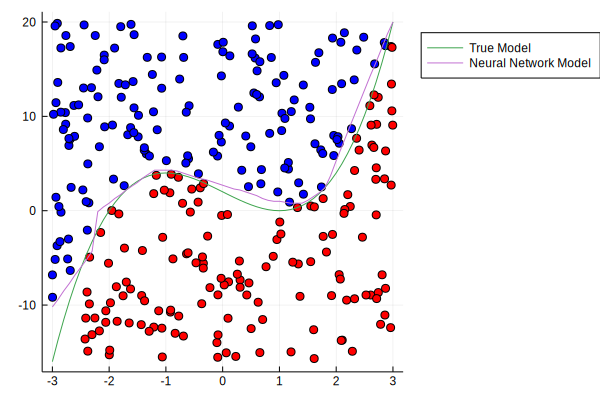

In [7]:
gif(anim)
plot_model(neural_model, x1grid, x2grid)